## Hi Nevo, here is the google colab link for the notebook , it looks much better there : 
https://colab.research.google.com/drive/1fV9dQUQJXYWC_f-0hLUJ-6iIeg2Astha#scrollTo=v0MX4xKWmkq5

In [86]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, ClassifierMixin
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import SMOTE
import imblearn
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings("ignore")





In [ ]:
work_df = pd.read_csv("/content/sample_data/train.csv")
work_df.head(5)

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,expensive
0,1,964081,13/08/2011,within a few hours,100%,87%,f,1,2,"['email', 'phone']",...,4.52,4.78,M130003350,f,1,1,0,0,1.22,1
1,2,801494,10/07/2011,within an hour,100%,100%,f,1,6,"['email', 'phone']",...,4.85,4.91,M130000243,t,1,0,1,0,1.87,0
2,3,5596383,24/03/2013,within an hour,100%,100%,f,1,4,"['email', 'phone']",...,4.91,4.88,M130001107,f,1,0,1,0,1.89,1
3,4,5686404,30/03/2013,NaN,NaN,NaN,f,2,5,"['email', 'phone']",...,4.67,4.75,M130007760,f,1,0,1,0,0.83,1
4,5,6809418,09/06/2013,within a day,100%,77%,t,1,2,"['email', 'phone']",...,4.98,4.91,M130000957,f,1,1,0,0,0.97,1


## Models

In [6]:
class LinearRegressionModel(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        # Add a column of ones for the bias term
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # Calculate weights using the normal equation
        self.weights = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.bias = self.weights[0]
        self.weights = self.weights[1:]

    def predict(self, X):
        # Add a column of ones for the bias term
        X = np.hstack((np.ones((X.shape[0], 1)), X))

        # Calculate predictions
        return X.dot(np.hstack((self.bias, self.weights)))

In [7]:
class MyLogisticRegression(BaseEstimator, ClassifierMixin):
    '''
    A class that implements logistic regression model with gradient descent.

    Parameters:
        learning_rate : float, optional (default=0.1)
            The learning rate determines the step size at each iteration during gradient descent.

        n_iterations : int, optional (default=1000)
            The number of iterations to perform during gradient descent.

    Attributes:
        weights : array
            The coefficients (weights) of the logistic regression model.

        bias : float
            The bias term of the logistic regression model.

    Methods:
        fit(X, y)
            Fit the logistic regression model to the training data.

        predict_proba(X)
            Calculate the prediction probabilities for the given features.

        predict(X, threshold=0.5)
            Make predictions using the logistic regression model.

    '''

    def __init__(self, learning_rate=1.1, n_iterations=3200):
        '''
        Initialize the logistic regression model.

        Parameters:
            learning_rate : float, optional (default=0.1)
                The learning rate determines the step size at each iteration during gradient descent.

            n_iterations : int, optional (default=1000)
                The number of iterations to perform during gradient descent.
        '''
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights, self.bias,self.coef_,self.classes_ = None, None , None,None


    @staticmethod
    def _sigmoid(x):
        '''
        Apply the sigmoid function to the given input.

        Parameters:
            x : float
                The input value.

        Returns:
            float
                The output value after applying the sigmoid function.
        '''
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def _binary_cross_entropy(y, y_hat):
        '''
        Calculate the binary cross-entropy loss between the actual classes and predicted probabilities.

        Parameters:
            y : array
                The true class labels.

            y_hat : array
                The predicted probabilities.

        Returns:
            float
                The binary cross-entropy loss value.
        '''
        def safe_from_zero_log(x):
            return 0 if x == 0 else np.log(x)
        total = 0
        for curr_y, curr_y_hat in zip(y, y_hat):
            total += (curr_y * safe_from_zero_log(curr_y_hat) + (1 - curr_y) * safe_from_zero_log(1 - curr_y_hat))
        return - total / len(y)

    def fit(self, X, y):
        '''
        Fit the logistic regression model to the training data using gradient descent.

        Parameters:
            X : array
                The feature matrix of shape (n_samples, n_features).

            y : array
                The target labels of shape (n_samples,).

        Returns:
            None
        '''
        # 1. Initialize coefficients
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # 2. Perform gradient descent
        for i in range(self.n_iterations):
            linear_pred = np.dot(X, self.weights) + self.bias
            probability = self._sigmoid(linear_pred)

            # Calculate derivatives
            partial_w = (1 / X.shape[0]) * (np.dot(X.T, (probability - y)))
            partial_d = (1 / X.shape[0]) * (np.sum(probability - y))

            # Update the coefficients
            self.weights -= self.learning_rate * partial_w
            self.bias -= self.learning_rate * partial_d
        self.coef_ = self.weights
        self.classes_ = np.unique(y)

    def predict_proba(self, X):
        '''
        Calculate the prediction probabilities for the given features.

        Parameters:
            X : array
                The feature matrix of shape (n_samples, n_features).

        Returns:
            array
                The prediction probabilities of shape (n_samples,).
        '''
        linear_pred = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_pred)

    def predict(self, X, threshold=0.5):
        '''
        Make predictions using the logistic regression model.

        Parameters:
            X : array
                The feature matrix of shape (n_samples, n_features).

            threshold : float, optional (default=0.5)
                The classification threshold to determine the predicted classes.

        Returns:
            array
                The predicted classes.
        '''
        probabilities = self.predict_proba(X)
        return [1 if i > threshold else 0 for i in probabilities]


In [8]:


class PCAModel:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eigenvalues = None
        self.eigenvectors = None

    def fit(self, X):
        # Center the data
        X_centered = X - np.mean(X, axis=0)

        # Compute the covariance matrix
        covariance_matrix = np.cov(X_centered.T)

        # Compute the eigenvalues and eigenvectors of the covariance matrix
        self.eigenvalues, self.eigenvectors = np.linalg.eig(covariance_matrix)

        # Sort the eigenvalues and eigenvectors in descending order
        eigenvalue_indices = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[eigenvalue_indices]
        self.eigenvectors = self.eigenvectors[:, eigenvalue_indices]

        # Select the top n_components eigenvectors
        if self.n_components is not None:
            self.eigenvalues = self.eigenvalues[:self.n_components]
            self.eigenvectors = self.eigenvectors[:, :self.n_components]

    def transform(self, X):
        # Center the data
        X_centered = X - np.mean(X, axis=0)

        # Project the data onto the eigenvectors
        transformed_data = np.dot(X_centered, self.eigenvectors)

        return transformed_data

    def scree_plot(self):
        explained_variance_ratio = self.eigenvalues / np.sum(self.eigenvalues)
        cum_variance_ratio = np.cumsum(explained_variance_ratio)

        plt.plot(range(1, len(explained_variance_ratio) + 1), cum_variance_ratio, 'bo-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title('Scree Plot')
        plt.grid(True)
        plt.ylim(0, 1)  # Set the y-axis range from 0 to 1
        plt.show()



##Exploratory Data Analysis


##### Variables



######Identification and Listing Information:


*   id
*   host_id
* host_response_time
* host_response_rate
* host_is_superhost
* host_listings_count
* host_verifications
* host_has_profile_pic
* host_identity_verified


######Property Information:


*   room_type
*   bathrooms_text
* property_type
* accommodates
* bathrooms_text
* bedrooms
* beds
* amenities
* latitude
* longitude



######Nights and Availability:


*   minimum_nights
*   maximum_nights
*   MiN_Max_Nights
* minimum_nights_avg_ntm
* maximum_nights_avg_ntm
* has_availability
* availability_30/60/90/365

######Review Information:


*   number_of_reviews
*   number_of_reviews_ltm/130d
*   first_review
* last_review
* review_scores_rating/accuracy/cleanliness/checkin/communication/location/value
* review_per_month

######Other Information:


*   license
*   instant_bookable
*   calculated_host_listings_count...

######Target Variable:


*   expensive


##### Checking regression ceofs and PCA Model

In [ ]:
work_df = pd.read_csv("/content/sample_data/train.csv")
def log_model_reg(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)
    train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train(train_df)

    # Extract the features and target variable from train_df
    y_train = target_column
    X_train = train_log_df

    # Create an instance of LogisticRegression classifier
    logistic_classifier = MyLogisticRegression()
    linear_classifier = LinearRegressionModel()
    sklearn_linear = LinearRegression()
    sklearn_logistic = LogisticRegression(solver="sag")


    # # Fit the classifier to the training data
    logistic_classifier.fit(X_train, y_train)
    sklearn_logistic.fit(X_train, y_train)
    linear_classifier.fit(X_train, y_train)
    sklearn_linear.fit(X_train, y_train)
    print(f' first 10 coefs of my logsitc regression : {logistic_classifier.weights[:10]}\n')
    print(f'First 10 coefficients of scikit-learn logistic regression: {sklearn_logistic.coef_[0][:10]}\n')
    print(f' first 10 coefs of my linear regression : {linear_classifier.weights[:10]}\n')
    print(f"First 10 coefficients of scikit-learn linear regression: {sklearn_linear.coef_[:10]}\n")

    # X_test = drop_low_correlation_columns(X_test,0.02,columns_to_drop)
    # y_pred = logistic_classifier.predict(X_test)
    # plot_confusion_matrix(Y_test,y_pred)
    # roc_auc(Y_test,y_pred)


    return None

log_model_reg(work_df)

<ipython-input-7-ed222074c430>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_df.corr()['expensive'].abs().sort_values(ascending=False)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


"['host_id'] not found in axis"
 first 10 coefs of my logsitc regression : [-0.33019077  0.01034478  0.13902929  0.07155014  0.08202118  0.05067056
 -0.06797255 -0.0099434  -0.08198383 -0.10601922]

First 10 coefficients of scikit-learn logistic regression: [-0.44120587 -0.11801096  0.1549673   0.26251531  0.11528582  0.29530967
  0.12452996 -0.44628803  0.01568338 -0.02224121]

 first 10 coefs of my linear regression : [ 1.92694165e+14  1.92694165e+14  1.92694165e+14  1.92694165e+14
  1.92694165e+14 -3.75939421e+14 -3.75939421e+14 -3.75939421e+14
  7.99146718e+13  7.99146718e+13]

First 10 coefficients of scikit-learn linear regression: [ 3.68649510e+12  3.68649510e+12  3.68649510e+12  3.68649510e+12
  3.68649510e+12 -5.77453228e+12 -5.77453228e+12 -5.77453228e+12
 -6.22619023e+11 -6.22619023e+11]



<ipython-input-5-ed222074c430>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_df.corr()['expensive'].abs().sort_values(ascending=False)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Transformed data for k=2 My PCA:

[[ 1.54109452  0.57802047]
 [-0.9994979   0.12621338]
 [ 1.10010466  0.45668062]
 [-0.55848864 -1.07156214]
 [-1.0129419   0.13945667]]
Transformed data for k=2 Sklearn PCA:

[[ 1.54109453 -0.57802048]
 [-0.9994979  -0.12621338]
 [ 1.10010466 -0.45668062]
 [-0.55848864  1.07156214]
 [-1.0129419  -0.13945667]]
Transformed data for k=3:

[[ 1.54109452  0.57802047 -0.62716377]
 [-0.9994979   0.12621338  0.7076164 ]
 [ 1.10010466  0.45668062 -0.94505986]
 [-0.55848864 -1.07156214  0.86454653]
 [-1.0129419   0.13945667  0.64235513]]
Transformed data for k=3 Sklearn PCA:

[[ 1.54109452 -0.57802047 -0.62716378]
 [-0.9994979  -0.12621338  0.7076164 ]
 [ 1.10010466 -0.45668062 -0.94505987]
 [-0.55848864  1.07156213  0.86454653]
 [-1.0129419  -0.13945667  0.64235513]]


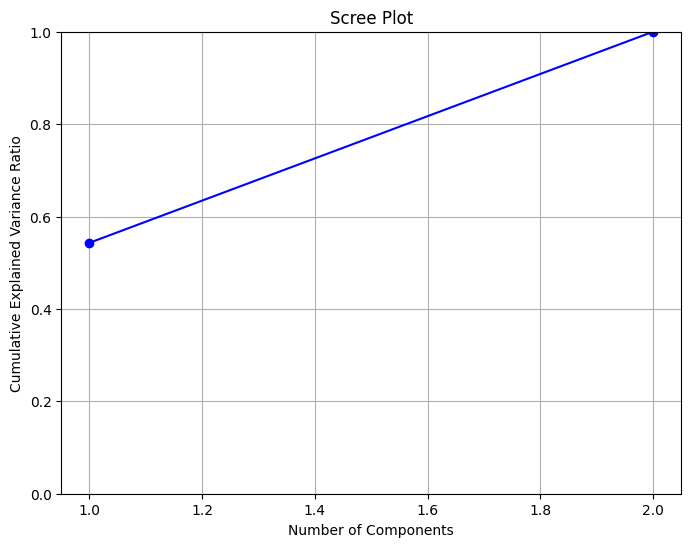

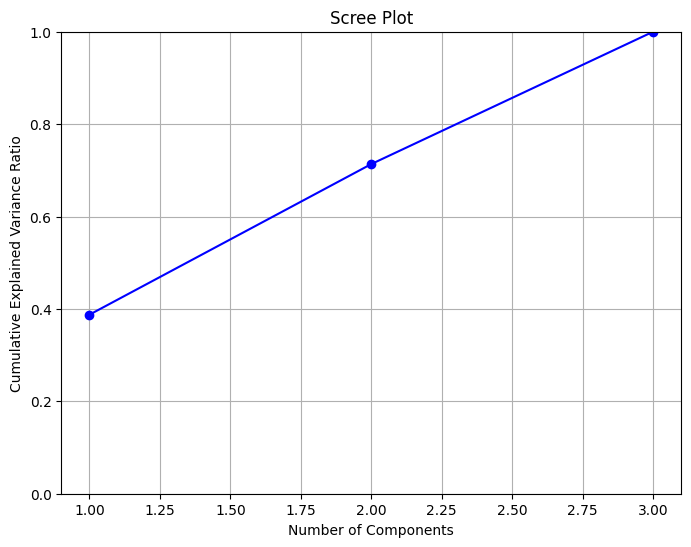

In [ ]:
work_df = pd.read_csv("/content/sample_data/train.csv")


def PCA_for_model(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)
    train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train(train_df)
    # Extract the features and target variable from train_df

    # Fit PCA with k=2
    sklearn_pca_2 = PCA(n_components=2)
    pca_2 = PCAModel(n_components=2)
    pca_2.fit(train_log_df)
    sklearn_pca_2.fit(train_log_df)
    transformed_data_2 = pca_2.transform(train_log_df)
    transformed_data_2_sk = sklearn_pca_2.transform(train_log_df)
    print("Transformed data for k=2 My PCA:\n")
    print(transformed_data_2[:5])
    print("Transformed data for k=2 Sklearn PCA:\n")
    print(transformed_data_2_sk[:5])


    # Fit PCA with k=3
    sklearn_pca_3 = PCA(n_components=3)
    pca_3 = PCAModel(n_components=3)
    pca_3.fit(train_log_df)
    sklearn_pca_3.fit(train_log_df)
    transformed_data_3 = pca_3.transform(train_log_df)
    transformed_data_3_sk = sklearn_pca_3.transform(train_log_df)
    print("Transformed data for k=3:\n")
    print(transformed_data_3[:5])
    print("Transformed data for k=3 Sklearn PCA:\n")
    print(transformed_data_3_sk[:5])

    # Scree plot for explained variance ratio
    plt.figure(figsize=(8, 6))
    pca_2.scree_plot()


    plt.figure(figsize=(8, 6))
    pca_3.scree_plot()


PCA_for_model(work_df)

As seen Scikit learn gets different values because it uses different solvers from our solver. We can Also see that the Logistic Regression coefs are much smaller than the Linear Regression coefs because of the logit function.

##### Distrubtion Graphs

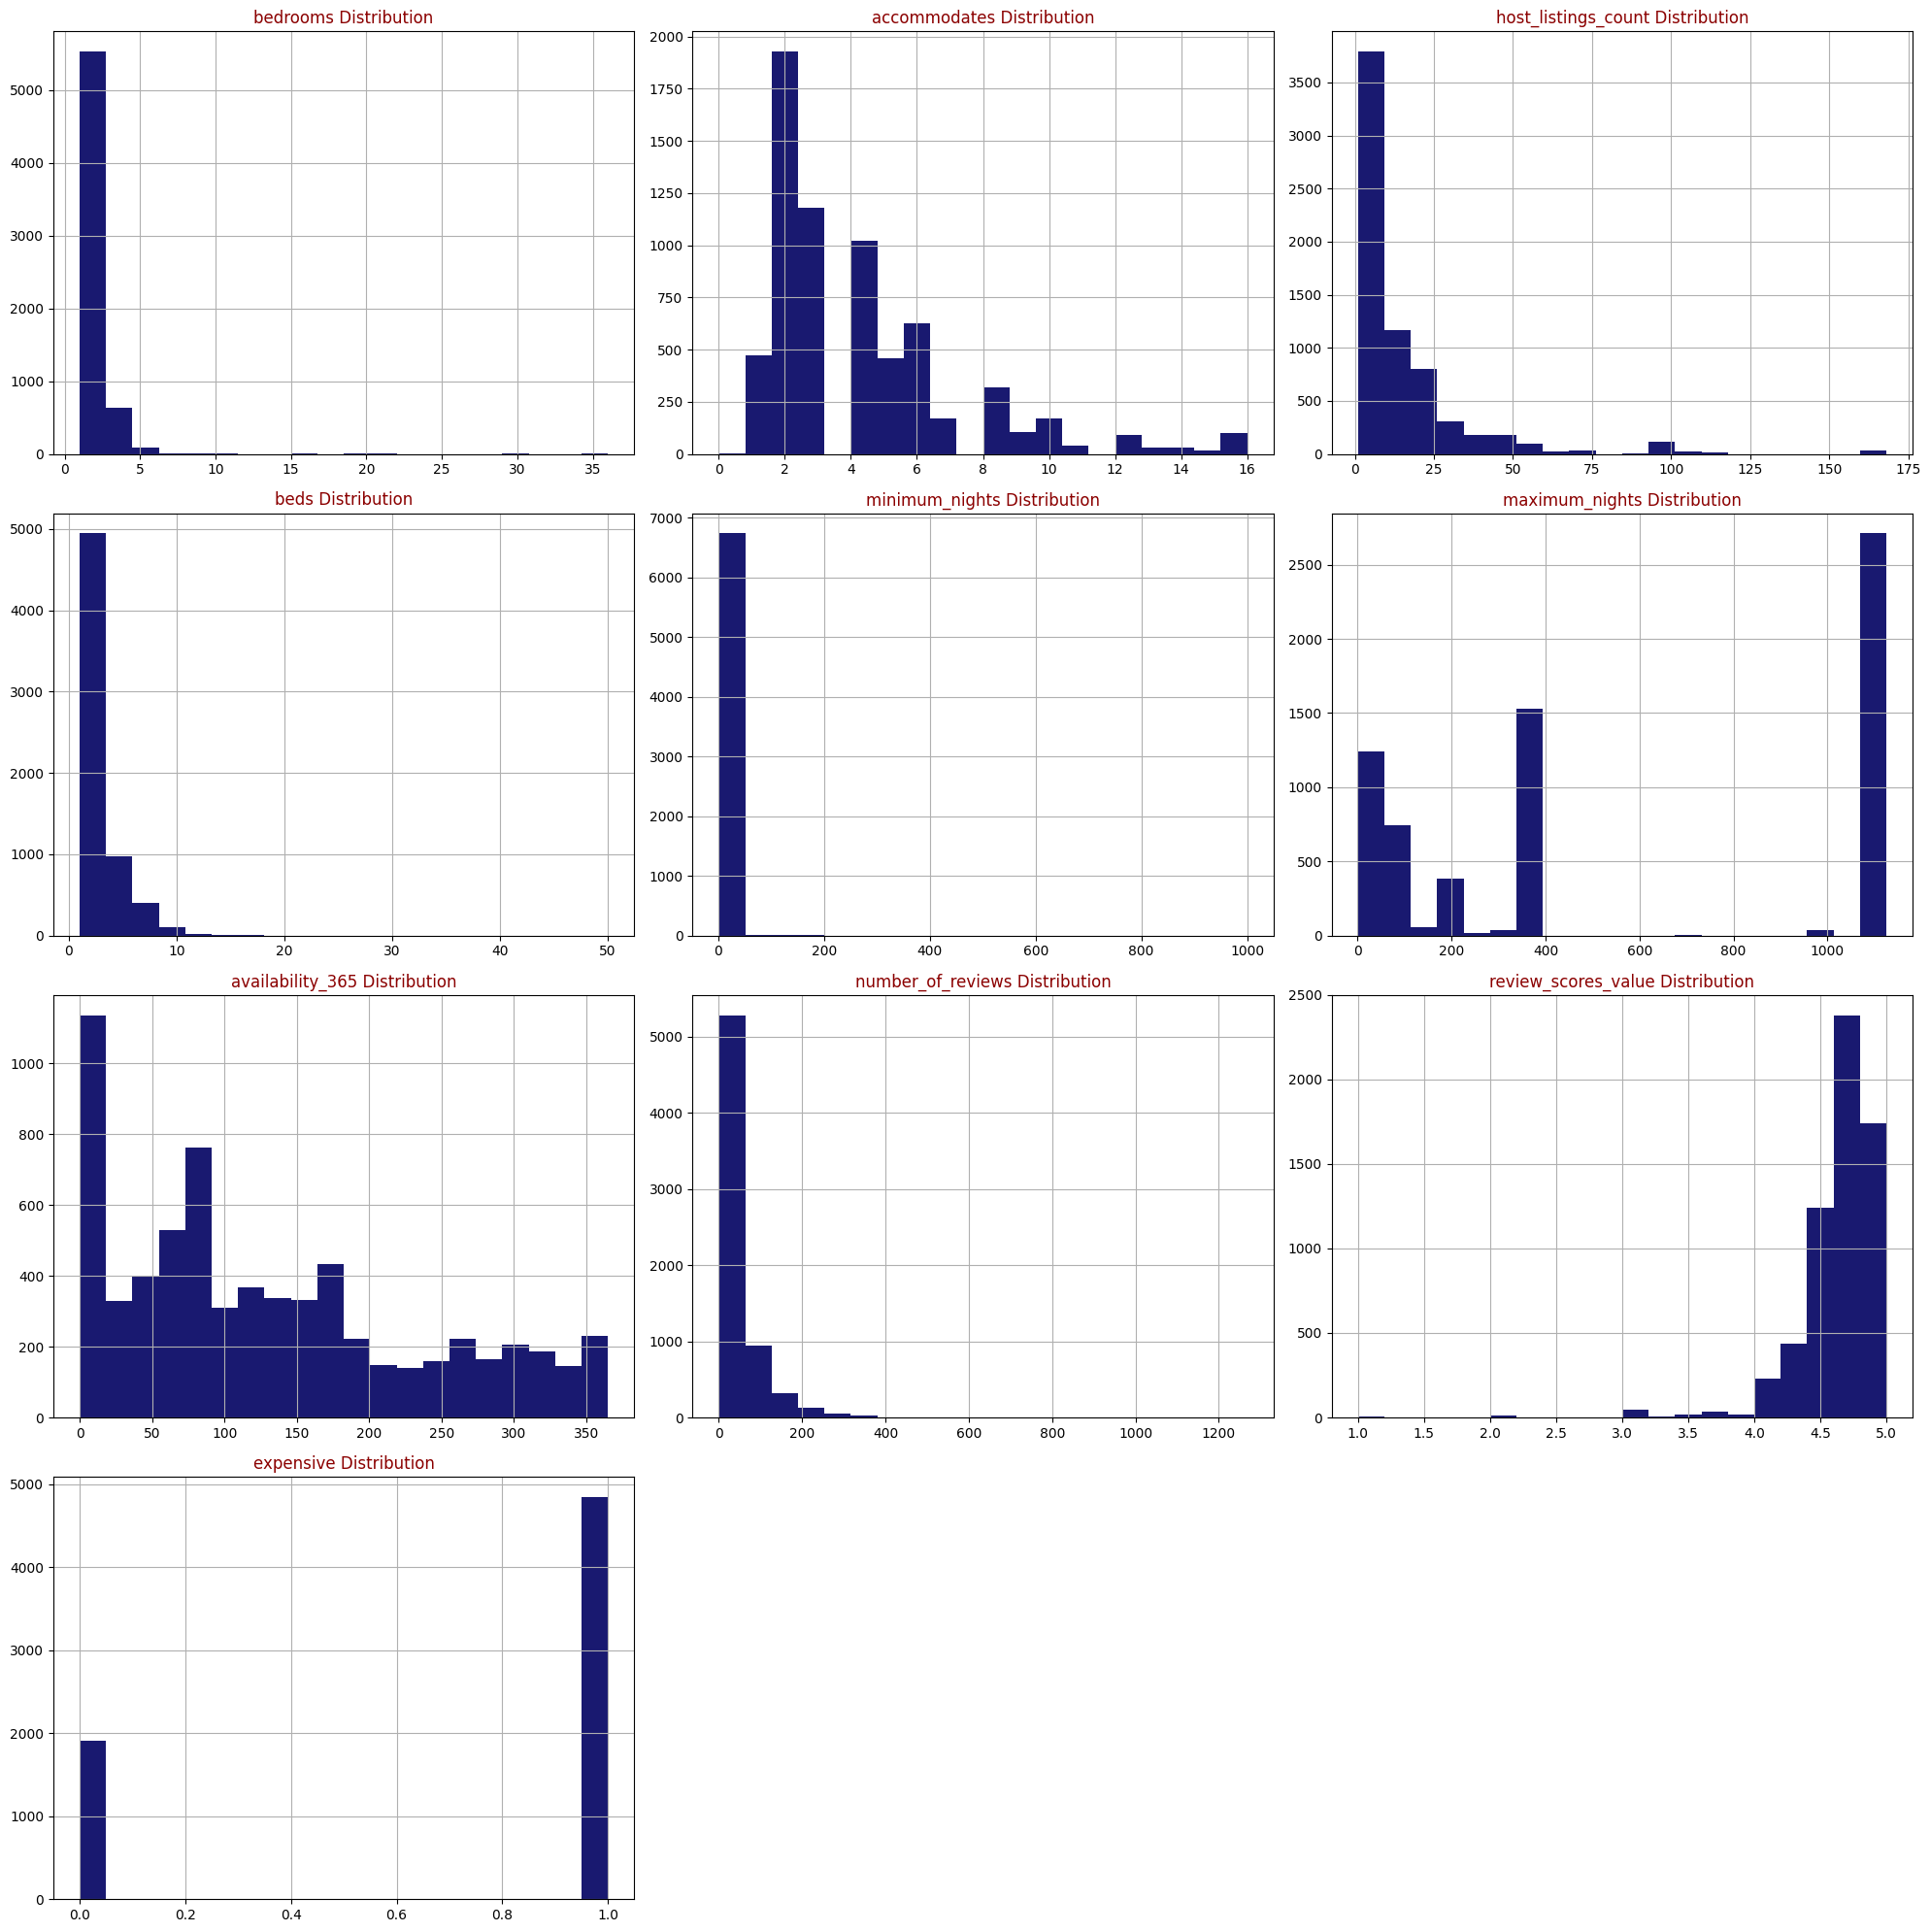

In [ ]:
def draw_histograms(dataframe, features, rows, cols):
    features = ['bedrooms', 'accommodates', 'host_listings_count','beds','minimum_nights','maximum_nights','availability_365','number_of_reviews','review_scores_value','expensive']

    fig = plt.figure(figsize=(20, 20))

    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins=20, ax=ax, facecolor='midnightblue')
        ax.set_title(feature + " Distribution", color='DarkRed')

    fig.tight_layout()
    plt.show()






draw_histograms(work_df,work_df.columns,4,3)

######Longitude and Latitude vs expensive (does the location matter)

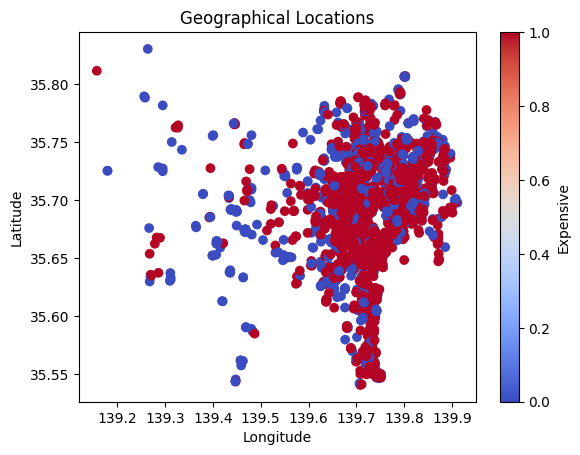

In [ ]:
work_df = pd.read_csv("/content/sample_data/train.csv")
# Extract longitude, latitude, and expensive columns
longitude = work_df['longitude']
latitude = work_df['latitude']
expensive = work_df['expensive']

# Create a scatter plot
plt.scatter(longitude, latitude, c=expensive, cmap='coolwarm')

# Set plot title and axis labels
plt.title('Geographical Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a colorbar legend
cbar = plt.colorbar()
cbar.set_label('Expensive', rotation=90)

# Show the plot
plt.show()






Looks like with longitdude over 139.55 there are more expensive listings , let's check:

In [ ]:
# Group the DataFrame by longitude being over 139.55
group_over = work_df.loc[work_df['longitude'] > 139.6].groupby('expensive')

# Calculate the value counts for each group
value_counts_over = group_over.size()

# Calculate the percentage for each group
percentage_over = value_counts_over / value_counts_over.sum() * 100

# Group the DataFrame by longitude being under 139.55
group_under = work_df.loc[work_df['longitude'] < 139.6].groupby('expensive')

# Calculate the value counts for each group
value_counts_under = group_under.size()

# Calculate the percentage for each group
percentage_under = value_counts_under / value_counts_under.sum() * 100

# Display the results
print("For longitude over 139.6:")
print("Value counts:")
print(value_counts_over)
print("\nPercentage:")
print(percentage_over)

print("\nFor longitude under 139.6:")
print("Value counts:")
print(value_counts_under)
print("\nPercentage:")
print(percentage_under)


For longitude over 139.6:
Value counts:
expensive
0    1776
1    4767
dtype: int64

Percentage:
expensive
0    27.143512
1    72.856488
dtype: float64

For longitude under 139.6:
Value counts:
expensive
0    137
1     79
dtype: int64

Percentage:
expensive
0    63.425926
1    36.574074
dtype: float64


As Seen it looks like the location does matter although there arent a lot of listings with longitude under 139.6 , it would be a nice feauture to add to the model to help it classify listings as 0.

##### Checking amenities corr to expensive

In [3]:
work_df = pd.read_csv("/content/sample_data/train.csv")

amenities_df = work_df['amenities'].str.get_dummies(sep=', ')
amenity_counts = amenities_df.apply(pd.Series.value_counts).sum().sort_values(ascending=False)

combined_df = pd.concat([work_df, amenities_df], axis=1)

correlation_matrix = combined_df[amenities_df.columns].corrwith(combined_df['expensive'])
sorted_correlations = correlation_matrix.sort_values(ascending=False)

print(sorted_correlations.head())
# amenities_df

"Bathtub"                  0.259297
"Private entrance"         0.216182
"Refrigerator"             0.186855
"Dishes and silverware"    0.185300
"Room-darkening shades"    0.174707
dtype: float64


In [79]:
amenity_counts = amenities_df[amenities_df == 1].count().sort_values(ascending=False)
correlation_counts_df = pd.DataFrame({'Correlation to Expensive': sorted_correlations, 'Count': amenity_counts})
correlation_counts_df = correlation_counts_df.sort_values(by='Correlation to Expensive', ascending=False)
correlation_counts_df.tail(10)

,Correlation to Expensive,Count
"""Paid washer \u2013 In building""",-0.057446,52
"""24\"" TV with standard cable""",-0.058064,14
"""Free washer \u2013 In building""",-0.063150,287
"""Private living room""",-0.071050,279
"[""Host greets you""",-0.071210,66
"""Books and reading material""",-0.071315,226
"""27\"" TV""",-0.079420,22
"""First aid kit""",-0.085903,1942
"""Host greets you""",-0.140861,424
"""Lock on bedroom door""",-0.256451,932


In [80]:
correlation_counts_df.tail(20)


,Correlation to Expensive,Count
"""Fast wifi \u2013 193 Mbps""",-0.038730,4
"""Washer""",-0.040505,4479
"""Shared patio or balcony""",-0.040816,204
"[""Refrigerator""",-0.042873,25
"""24\"" HDTV with standard cable""",-0.043305,5
"""Dryer""",-0.047607,1839
"""Luggage dropoff allowed""",-0.049220,2221
"""Paid parking off premises""",-0.049436,1540
"[""Microwave""",-0.052720,10
"""Shared backyard \u2013 Not fully fenced""",-0.054941,33


###### Looks like it would be worth adding amnites to the model , will do so in feature engenneing function

##### Checking which columns have corraltion to not expensive (0)

In [ ]:
df = pd.read_csv("/content/sample_data/train.csv")
# Calculate correlation with the target variable (0s)
correlation = df.corrwith(df['expensive'].apply(lambda x: 1 if x == 0 else 0))

# Sort the correlation values in descending order
correlation = correlation.sort_values(ascending=False)

# Print the columns with high correlation to 0s
print(correlation)
top_corr_vars = correlation.index[:3]  # Exclude the first element since it corresponds to "expensive" itself


calculated_host_listings_count_shared_rooms     0.203107
calculated_host_listings_count_private_rooms    0.115817
calculated_host_listings_count                  0.100377
review_scores_value                             0.092877
minimum_maximum_nights                          0.074973
latitude                                        0.065332
review_scores_checkin                           0.055350
maximum_nights                                  0.042369
minimum_minimum_nights                          0.038990
minimum_nights                                  0.037718
host_listings_count                             0.036156
review_scores_communication                     0.034656
minimum_nights_avg_ntm                          0.032574
review_scores_accuracy                          0.028555
maximum_minimum_nights                          0.026748
host_total_listings_count                       0.006896
review_scores_cleanliness                      -0.017973
maximum_nights_avg_ntm         

<ipython-input-52-11462821e485>:3: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corrwith(df['expensive'].apply(lambda x: 1 if x == 0 else 0))


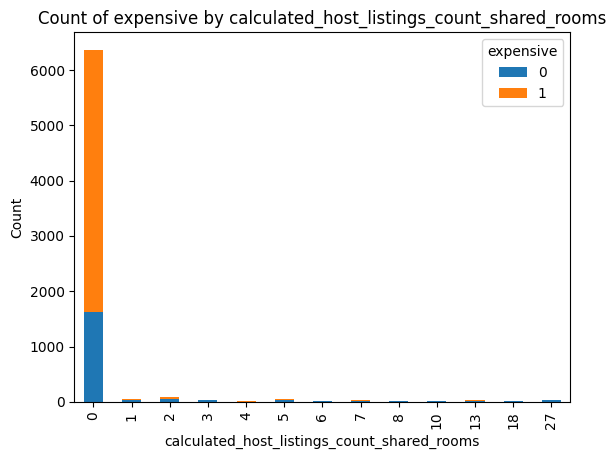

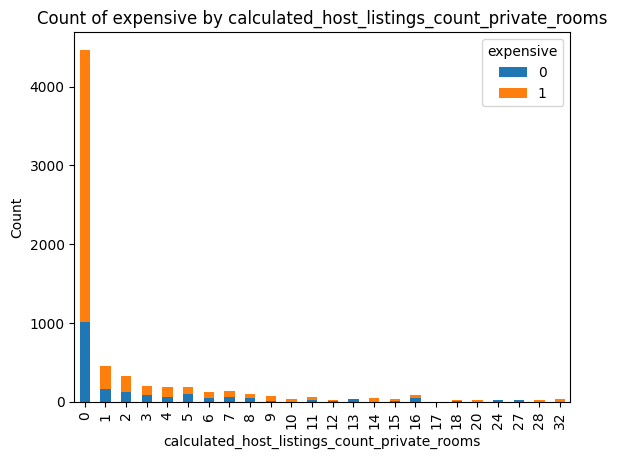

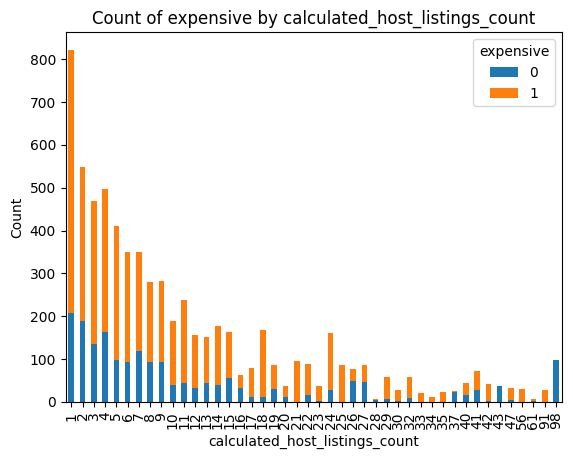

In [ ]:
for var in top_corr_vars:
    grouped = df.groupby(var)['expensive'].value_counts().unstack().fillna(0)

    grouped.plot(kind='bar', stacked=True)
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.title(f'Count of expensive by {var}')
    plt.legend(title='expensive', labels=['0', '1'])
    plt.show()

##### Counts and Stats

In [ ]:
work_df.describe()

,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,expensive
count,6759.000000,6.759000e+03,6759.000000,6759.000000,6759.000000,6759.000000,6759.000000,6267.000000,6477.000000,6759.000000,...,6169.000000,6169.000000,6169.000000,6169.000000,6759.000000,6759.000000,6759.000000,6759.000000,6175.000000,6759.000000
mean,3380.000000,1.881663e+08,15.044829,22.584110,35.698990,139.734674,4.229176,1.477900,2.677783,2.886226,...,4.791559,4.797538,4.681952,4.637217,12.395325,8.067170,2.223850,0.427726,1.031501,0.716970
std,1951.299567,1.142974e+08,20.796970,33.227591,0.039322,0.075790,2.996842,1.231935,2.444584,15.872231,...,0.282483,0.299521,0.309749,0.332595,15.650376,10.880906,4.959593,2.525644,1.142974,0.450504
min,1.000000,7.716940e+05,1.000000,1.000000,35.540630,139.157320,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.020000,0.000000
25%,1690.500000,7.173565e+07,4.000000,5.000000,35.688235,139.698795,2.000000,1.000000,1.000000,1.000000,...,4.730000,4.750000,4.570000,4.530000,3.000000,1.000000,0.000000,0.000000,0.330000,0.000000
50%,3380.000000,2.012103e+08,8.000000,11.000000,35.704020,139.728820,3.000000,1.000000,2.000000,1.000000,...,4.870000,4.870000,4.750000,4.690000,7.000000,4.000000,0.000000,0.000000,0.740000,1.000000
75%,5069.500000,2.877208e+08,18.000000,26.000000,35.720230,139.788160,6.000000,2.000000,3.000000,2.000000,...,4.960000,4.970000,4.880000,4.830000,15.000000,12.000000,2.000000,0.000000,1.340000,1.000000
max,6759.000000,4.609914e+08,168.000000,462.000000,35.830640,139.911580,16.000000,36.000000,50.000000,1000.000000,...,5.000000,5.000000,5.000000,5.000000,98.000000,77.000000,32.000000,27.000000,24.030000,1.000000


In [ ]:
work_df.expensive.value_counts()

1    4846
0    1913
Name: expensive, dtype: int64

As we can see we have much more 1s than 0s in expensive so it makes sense that our model will be bias therfore we will use oversampleing to balance the data frame using SMOTE from sklearn

## Data Preproccessing

##### Detect Outliers with LOF

In [47]:
def detect_outliers_lof(df, contamination=0.05):
    # Create LOF model
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)

    # Fit the model and get outlier scores
    outlier_scores = lof.fit_predict(df)

    # Identify outliers (negative scores indicate outliers)
    outliers = df[outlier_scores == -1]

    # Remove outliers from the DataFrame
    df_cleaned = df.drop(outliers.index, axis=0)

    return df_cleaned


##### Corr function

In [48]:
def corr_not_meeted_columns(train_df):
    if 'expensive' in train_df.columns:
        correlation = train_df.corr()['expensive'].abs().sort_values(ascending=False)
        columns_to_drop = correlation[correlation < 0.1].index.tolist()
        return columns_to_drop
    else:
        print("'expensive' column not found in the DataFrame.")
        return []

def drop_low_correlation_columns(df, target_column='expensive', threshold=0.02, columns_to_drop_input=None):
    # Calculate the correlation matrix with the target column
    correlation_matrix = df.corr()[target_column]

    # Get the columns to drop
    if columns_to_drop_input is None:
        columns_to_drop = correlation_matrix[correlation_matrix.abs() < threshold].index.tolist()
    else:
        columns_to_drop = [col for col in columns_to_drop_input if col in df.columns]

    # Drop the columns from the DataFrame
    df_dropped = df.drop(columns=columns_to_drop)

    return df_dropped, columns_to_drop

##### Show Unique Function

In [49]:
def show_unique(train_df):
    unique_value_counts = train_df.nunique()
    print(unique_value_counts)
# show_unique(work_df)


##### Number of NAs Function

In [50]:
def num_na(train_df):
    na_counts = train_df.isna().sum()
    for column, count in na_counts.items():
        if count > 0:
            print(f"Column '{column}': {count} NA values")
# num_na(train_df)

##### Data preproccessing function

In [51]:
def data_preprocessing(df):

    # Clean the 'bathrooms_text' column and extract the numeric values
    df['num_baths'] = df['bathrooms_text'].str.extract(r'(\d+\.?\d*)')

    # Replace 'Shared half-bath' with 0.5 in the 'num_baths' column
    df['num_baths'] = df['num_baths'].replace('Shared half-bath', '0.5')

    # Convert 'num_baths' column to numeric
    df['num_baths'] = pd.to_numeric(df['num_baths'])

    df['host_response_time'] = df['host_response_time'].fillna('Unknown')

    columns_to_fill = ['review_scores_rating', 'review_scores_accuracy',
                       'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                       'review_scores_location', 'review_scores_value', 'bedrooms', 'beds','minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
                        'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']

    for column in columns_to_fill:
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)

    # Fill NaN values in 'months_between_reviews' column with the mean
    mean_months = df['months_between_reviews'].mean()
    df['months_between_reviews'].fillna(mean_months, inplace=True)

    # Fill NaN values in 'reviews_per_month' column with the mean
    mean_reviews_per_month = df['reviews_per_month'].mean()
    df['reviews_per_month'].fillna(mean_reviews_per_month, inplace=True)

    # Fill NaN values in 'num_baths' column with the mean
    mean_num_baths = df['num_baths'].mean()
    df['num_baths'].fillna(mean_num_baths, inplace=True)

    # columns_to_impute = ['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
    #                     'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']

    # # Create a SimpleImputer object with strategy='mean'
    # imputer = SimpleImputer(strategy='mean')

    # # Fit the imputer on the columns with NaN values
    # imputer.fit(train_df[columns_to_impute])

    # # Transform the NaN values with the mean value
    # train_df[columns_to_impute] = imputer.transform(train_df[columns_to_impute])


    return df





In This Function I used a 'mean' staratagy to fill na values and in the handle_final_nan functon I used most frequent value for replaceing catagorial nan values.

In [52]:

def fancy_data_preprocessing(df):
    # Clean the 'bathrooms_text' column and extract the numeric values
    df['num_baths'] = df['bathrooms_text'].str.extract(r'(\d+\.?\d*)')

    # Replace 'Shared half-bath' with 0.5 in the 'num_baths' column
    df['num_baths'] = df['num_baths'].replace('Shared half-bath', '0.5')

    # Convert 'num_baths' column to numeric
    df['num_baths'] = pd.to_numeric(df['num_baths'])

    df['host_response_time'] = df['host_response_time'].fillna('Unknown')

    columns_to_fill = ['review_scores_rating', 'review_scores_accuracy',
                       'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                       'review_scores_location', 'review_scores_value', 'bedrooms', 'beds',
                       'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
                       'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']

    # Fill missing values using KNN imputation
    imputer = KNN()
    df[columns_to_fill] = imputer.fit_transform(df[columns_to_fill])

    return df







In this method we used KNN to impute na values

##### Handle Final Nan Values

In [53]:
def handle_final_missing_values(df):
    # Find columns with missing values
    columns_with_na = df.columns[df.isna().any()].tolist()

    # Fill missing values with mean for numerical columns
    numerical_columns = df.select_dtypes(include=['float', 'int']).columns
    numerical_na_columns = [col for col in columns_with_na if col in numerical_columns]
    df[numerical_na_columns] = df[numerical_na_columns].fillna(df[numerical_na_columns].mean())

    # Fill missing values with most frequent value for categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    categorical_na_columns = [col for col in columns_with_na if col in categorical_columns]
    for col in categorical_na_columns:
        most_frequent_value = df[col].mode()[0]
        df[col] = df[col].fillna(most_frequent_value)

    return df

##### amnities parsing and features

In [81]:
def parse_amenities_as_features(df, column):
    '''
    INPUT:
    df - pandas pd.DataFrame containing the column, the column must contain a list for every record.
         For reference, look at the column amenities and host_verifications
    column - python string containing a column name

    OUTPUT:
    df - pandas pd.DataFrame with additional columns representing each unique feature in the specified column

    The function parses the values in the specified column as features and adds them as additional columns to the dataframe.
    '''
    unique_list = df[column].unique().tolist()
    unique_features = list()
    for i in unique_list:
        unique_features.extend(eval(i))
    unique_features = list(set(unique_features))
    print('{} column contains {} unique features'.format(column, len(unique_features)))
    print('{} features parsed and added'.format(column))

    for feature in unique_features:
        df[feature] = df[column].apply(lambda x: int(feature in eval(x)))

    return df

def add_amenity_columns(df):
    '''
    INPUT:
    df - pandas DataFrame containing the amenities column

    OUTPUT:
    df - pandas DataFrame with added columns indicating presence of specified amenities

    The function checks if the specified amenities are present in the amenities column of the DataFrame.
    It adds columns to the DataFrame indicating the presence of each amenity (1 if present, 0 if not).
    It also prints the counts where the value equals 1 for each amenity.
    '''
    amenities_to_check = ['Bathtub', 'Private entrance', 'Refrigerator',
       'Dishes and silverware', 'Room-darkening shades', 'Microwave',
       'Hot water', 'Elevator', 'Rice maker', 'Conditioner', 'Stove',
        'Self check-in', 'Bidet',
       'Body soap', 'Shower gel', 'Freezer', 'Ethernet connection',
       'Smart lock', 'Dining table', 'Hot water kettle', 'Kitchen',
        'TV', 'Hangers', 'Bed linens',
       'Cleaning products', 'Iron',
       'Private patio or balcony', 'Drying rack for clothing',
       'Pocket wifi', 'Patio or balcony', 'Hair dryer',
       'Clothing storage', 'Clothing storage: closet', 'Induction stove',
       'Essentials', 'Keypad', 'City skyline view',
       'Outdoor furniture', 'Carbon monoxide alarm', 'Dishwasher',
       'Dedicated workspace', 'Single level home', 'Toaster', 'Netflix',
       'Laundromat nearby', 'Safe', 'Wine glasses','First aid kit' ,
       'Host greets you','Lock on bedroom door','Paid parking off premises','Luggage dropoff allowed','Dryer','Washer']

    for amenity in amenities_to_check:
        df[amenity] = df['amenities'].str.contains(amenity).astype(int)
        # count = df[df[amenity] == 1][amenity].count()
        # print(f"Count of {amenity}: {count}")

    return df


In [55]:
# def add_amenity_columns(df):
#     '''
#     INPUT:
#     df - pandas DataFrame containing the amenities column

#     OUTPUT:
#     df - pandas DataFrame with added columns indicating presence of specified amenities

#     The function checks if the specified amenities are present in the amenities column of the DataFrame.
#     It adds columns to the DataFrame indicating the presence of each amenity (1 if present, 0 if not).
#     It also prints the counts where the value equals 1 for each amenity.
#     '''
#     amenities_to_check = ['Bathtub', 'Private entrance', 'Refrigerator',
#        'Dishes and silverware', 'Room-darkening shades', 'Microwave',
#        'Hot water', 'Elevator', 'Rice maker', 'Conditioner', 'Stove',
#         'Self check-in', 'Bidet',
#        'Body soap', 'Shower gel', 'Freezer', 'Ethernet connection',
#        'Smart lock', 'Dining table', 'Hot water kettle', 'Kitchen',
#         'TV', 'Hangers', 'Bed linens',
#        'Cleaning products', 'Iron',
#        'Private patio or balcony', 'Drying rack for clothing',
#        'Pocket wifi', 'Patio or balcony', 'Hair dryer',
#        'Clothing storage', 'Clothing storage: closet', 'Induction stove',
#        'Essentials', 'Keypad', 'City skyline view',
#        'Outdoor furniture', 'Carbon monoxide alarm', 'Dishwasher',
#        'Dedicated workspace', 'Single level home', 'Toaster', 'Netflix',
#        'Laundromat nearby', 'Safe', 'Wine glasses']

#     for amenity in amenities_to_check:
#         df[amenity] = df['amenities'].str.contains(amenity).astype(int)
#         count = df[df[amenity] == 1][amenity].count()
#         print(f"Count of {amenity}: {count}")

#     return df

# # Example usage
# work_df = pd.read_csv("/content/sample_data/train.csv")
# work_df = add_amenity_columns(work_df)


#####Feature Engineering

In [56]:
def feature_engineering(df):
    # Remove '%' from 'host_response_rate' and 'host_acceptance_rate'
    df['host_response_rate'] = df['host_response_rate'].str.replace('%', '')
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '')

    # Convert 'host_response_rate' and 'host_acceptance_rate' columns to numeric
    df['host_response_rate'] = pd.to_numeric(df['host_response_rate'])
    df['host_acceptance_rate'] = pd.to_numeric(df['host_acceptance_rate'])

    # Create new columns indicating whether 'host_response_rate' is over 80 or not
    df['response_rate_over_80'] = (df['host_response_rate'] > 80).astype(int)

    # Create new columns indicating whether 'host_acceptance_rate' is over 80 or not
    df['acceptance_rate_over_80'] = (df['host_acceptance_rate'] > 80).astype(int)

    # Create 'amenities_length' column
    df['amenities_length'] = df['amenities'].apply(lambda x: len(x.split(',')))

    # Create new column indicating whether longitude is ומגקר 139.6 or not
    df['longitude_under_139.6'] = (df['longitude'] < 139.6).astype(int)

    # Convert 'first_review' and 'last_review' to datetime format
    df['first_review'] = pd.to_datetime(df['first_review'], format="%d/%m/%Y")
    df['last_review'] = pd.to_datetime(df['last_review'], format="%d/%m/%Y")

    # Calculate the number of months between first and last review
    df['months_between_reviews'] = (df['last_review'] - df['first_review']) / np.timedelta64(1, 'M')
    # Calculate the average_availability
    df['average_availability'] = df[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean(axis=1)


    return df

def feature_engineering_with_amenities(df):
    # Remove '%' from 'host_response_rate' and 'host_acceptance_rate'
    df['host_response_rate'] = df['host_response_rate'].str.replace('%', '')
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '')

    # Convert 'host_response_rate' and 'host_acceptance_rate' columns to numeric
    df['host_response_rate'] = pd.to_numeric(df['host_response_rate'])
    df['host_acceptance_rate'] = pd.to_numeric(df['host_acceptance_rate'])

    # Create new columns indicating whether 'host_response_rate' is over 80 or not
    df['response_rate_over_80'] = (df['host_response_rate'] > 80).astype(int)

    # Create new columns indicating whether 'host_acceptance_rate' is over 80 or not
    df['acceptance_rate_over_80'] = (df['host_acceptance_rate'] > 80).astype(int)

    # Create 'amenities_length' column
    df['amenities_length'] = df['amenities'].apply(lambda x: len(x.split(',')))

    # Create new column indicating whether longitude is less than 139.6 or not
    df['longitude_under_139.6'] = (df['longitude'] < 139.6).astype(int)

    # Convert 'first_review' and 'last_review' to datetime format
    df['first_review'] = pd.to_datetime(df['first_review'], format="%d/%m/%Y")
    df['last_review'] = pd.to_datetime(df['last_review'], format="%d/%m/%Y")

    # Calculate the number of months between first and last review
    df['months_between_reviews'] = (df['last_review'] - df['first_review']) / np.timedelta64(1, 'M')
    # Calculate the average_availability
    df['average_availability'] = df[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean(axis=1)

    # Parse amenities as features
    df = add_amenity_columns(df)

    return df


Created new columns :
* longitude_under_139.6 - binary (0,1)
* average_availability
* months_between_reviews
* acceptance_rate_over_80
* response_rate_over_80
* amenities_length




#####Drop Columns

In [57]:
def drop_irrelevant_columns(train_df, corr_columns):
    try:
        train_df = train_df.drop('host_since', axis=1)
        # Drop old columns
        # train_df = train_df.drop('host_id', axis=1)
        train_df = train_df.drop('id', axis=1)
        # train_df = train_df.drop('host_response_rate', axis=1)
        train_df = train_df.drop('host_acceptance_rate', axis=1)
        train_df = train_df.drop('bathrooms_text', axis=1)
        train_df = train_df.drop('first_review', axis=1)
        train_df = train_df.drop('last_review', axis=1)
        train_df = train_df.drop('license', axis=1)
        train_df = train_df.drop('amenities', axis=1)
        train_df = train_df.drop(['availability_30', 'availability_60', 'availability_90', 'availability_365'], axis=1)
        corr_columns = list(set(corr_columns).intersection(train_df.columns))
        train_df = train_df.drop(columns=corr_columns + ['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'])
        train_df.dropna(inplace=True)
    except KeyError as e:
        # train_df.dropna(inplace=True)
        print(e)
    return train_df

def drop_irrelevant_columns_test(train_df, corr_columns):
    try:
        train_df = train_df.drop('host_since', axis=1)
        # Drop old columns
        # train_df = train_df.drop('host_id', axis=1)
        train_df = train_df.drop('id', axis=1)
        # train_df = train_df.drop('host_response_rate', axis=1)
        train_df = train_df.drop('host_acceptance_rate', axis=1)
        train_df = train_df.drop('bathrooms_text', axis=1)
        train_df = train_df.drop('first_review', axis=1)
        train_df = train_df.drop('last_review', axis=1)
        train_df = train_df.drop('license', axis=1)
        train_df = train_df.drop('amenities', axis=1)
        train_df = train_df.drop(['availability_30', 'availability_60', 'availability_90', 'availability_365'], axis=1)
        train_df = train_df.drop(columns=corr_columns + ['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'])
        # num_na(train_df)
    except KeyError as e:
        print(e)
    return train_df


#####One Hot Encoder

In [58]:
def encode_categorical_features(data, encoder=None):
    # Select categorical columns
    categorical_cols = data.select_dtypes(include=['object']).columns

    # Perform one-hot encoding
    if encoder is None:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        encoded_features = encoder.fit_transform(data[categorical_cols])
    else:
        encoded_features = encoder.transform(data[categorical_cols])

    # Retrieve feature names after one-hot encoding
    encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

    # Create a DataFrame of the encoded features
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=data.index)

    # Select numerical columns
    numerical_cols = data.select_dtypes(exclude=['object']).columns

    # Concatenate the encoded categorical variables with the numerical variables
    encoded_data = pd.concat([encoded_df, data[numerical_cols]], axis=1)

    return encoded_data, encoder







#####Normalization and Standartztion

In [59]:
def normalize_data(df, scaler=None):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(df[numerical_cols])

    df[numerical_cols] = scaler.transform(df[numerical_cols])

    return df, scaler

def standardize_data(df, scaler=None):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

    if scaler is None:
        # Standardize the numerical columns
        scaler = StandardScaler()
        df_standardized = scaler.fit_transform(df[numerical_cols])
    else:
        df_standardized = scaler.transform(df[numerical_cols])

    # Create a new DataFrame with the standardized values
    df_standardized = pd.DataFrame(df_standardized, columns=numerical_cols)

    # Update the original DataFrame with the standardized numerical values
    df[numerical_cols] = df_standardized

    return df, scaler

In [60]:
# def drop_irrelevant_columns(train_features, test_df):
#     # Get the columns present in the train features
#     train_columns = train_features

#     # Check if any columns in the test dataframe are not present in the train features
#     irrelevant_columns = [col for col in test_df.columns if col not in train_columns]

#     # Drop the irrelevant columns from the test dataframe
#     test_df_dropped = test_df.drop(columns=irrelevant_columns, errors='ignore')

#     return test_df_dropped

#####Wrapper function for preparing data

In [61]:


def prepare_data_for_fitting_log_lin_train_amnities(train_df):
  train_df = feature_engineering_with_amenities(train_df)
  train_df = data_preprocessing(train_df)
  columns_to_drop = corr_not_meeted_columns(train_df)
  train_df = drop_irrelevant_columns(train_df,columns_to_drop)
  target_column = train_df['expensive'].values
  train_df = train_df.drop('expensive', axis=1)
  train_df , scaler = normalize_data(train_df)
  train_df,encoder = encode_categorical_features(train_df)
  train_df = handle_final_missing_values(train_df)
  oversample = SMOTE()
  train_df, target_column = oversample.fit_resample(train_df, target_column)
  return train_df , scaler , target_column, encoder,columns_to_drop

def prepare_data_for_fitting_log_lin_train_oversample(train_df):
  train_df = feature_engineering(train_df)
  train_df = data_preprocessing(train_df)
  columns_to_drop = corr_not_meeted_columns(train_df)
  train_df = drop_irrelevant_columns(train_df,columns_to_drop)
  target_column = train_df['expensive'].values
  train_df = train_df.drop('expensive', axis=1)
  train_df , scaler = normalize_data(train_df)
  train_df,encoder = encode_categorical_features(train_df)
  train_df = handle_final_missing_values(train_df)
  oversample = SMOTE()
  train_df, target_column = oversample.fit_resample(train_df, target_column)
  return train_df , scaler , target_column, encoder,columns_to_drop


def prepare_data_for_fitting_log_lin_test(test_df,train_scaler,train_encoder,columns_to_drop):
  test_df = feature_engineering(test_df)
  test_df = data_preprocessing(test_df)
  test_df = drop_irrelevant_columns(test_df,columns_to_drop)
  target_column = test_df['expensive'].values
  test_df = test_df.drop('expensive', axis=1)
  test_df,_  = normalize_data(test_df,scaler=train_scaler)
  test_df,_ = encode_categorical_features(test_df,encoder=train_encoder)
  test_df = handle_final_missing_values(test_df)
  return test_df,target_column

def prepare_data_for_fitting_log_lin_test_amnities(test_df,train_scaler,train_encoder,columns_to_drop):
  test_df = feature_engineering_with_amenities(test_df)
  test_df = data_preprocessing(test_df)
  test_df = drop_irrelevant_columns(test_df,columns_to_drop)
  target_column = test_df['expensive'].values
  test_df = test_df.drop('expensive', axis=1)
  test_df,_  = normalize_data(test_df,scaler=train_scaler)
  test_df,_ = encode_categorical_features(test_df,encoder=train_encoder)
  test_df = handle_final_missing_values(test_df)
  return test_df,target_column


def prepare_data_for_fitting_public_test(test_df,train_scaler,train_encoder,columns_to_drop):
  test_df = feature_engineering(test_df)
  test_df = data_preprocessing(test_df)
  test_df = drop_irrelevant_columns_test(test_df,columns_to_drop)
  test_df,_  = normalize_data(test_df,scaler=train_scaler)
  test_df,_ = encode_categorical_features(test_df,encoder=train_encoder)
  test_df = handle_final_missing_values(test_df)
  return test_df

def prepare_data_for_fitting_public_test_amnities(test_df,train_scaler,train_encoder,columns_to_drop):
  test_df = feature_engineering_with_amenities(test_df)
  test_df = data_preprocessing(test_df)
  test_df = drop_irrelevant_columns_test(test_df,columns_to_drop)
  test_df,_  = normalize_data(test_df,scaler=train_scaler)
  test_df,_ = encode_categorical_features(test_df,encoder=train_encoder)
  test_df = handle_final_missing_values(test_df)
  return test_df




def prepare_data_for_fitting_PCA(train_df):
  train_df = feature_engineering(train_df)
  train_df = data_preprocessing(train_df)
  train_df = drop_irreleveant_columns(train_df)
  train_df = encode_categorical_features(train_df)
  train_df = standardize_data(train_df)
  return train_df



As we can see we are using the preproccesing methods for the training set and the testing set

#####Confusion matrix function

In [62]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    display_labels = np.unique(np.concatenate((y_true, y_pred)))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap='Blues')

    classification_rep = classification_report(y_true, y_pred)

    plt.title('Confusion Matrix\nClassification Report:\n{}'.format(classification_rep))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # print('Classification Report:')
    # print(classification_rep)

    plt.show()


#####Print Threshold vs true function

In [63]:
def print_threshhold_real_linereg(X_test,classifier,y_true_test):
    # Calculate the test thresholds for all samples
  thresholds = X_test.dot(classifier.coef_) + classifier.intercept_

  # Predict the values based on the test thresholds
  y_pred = classifier.predict(X_test)

  # Print the test thresholds and their predicted values
  for threshold, pred,true in zip(thresholds, y_pred,y_true_test):
      print("Threshold:", threshold, "Predicted Value:", pred,"Real Value: ", true )

#####AUC and ROC functions

In [90]:
def roc_auc(y_true,y_pred):
  # Assuming you have y_true and y_pred from your classification models

  # Calculate the AUC
  auc1 = roc_auc_score(y_true, y_pred)

  # Calculate the false positive rate (fpr) and true positive rate (tpr) for the ROC curve
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)

  # Plot the ROC curve
  plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % auc1)
  plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line for random guessing
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')
  plt.show()
  return auc1

##### Blanced Dataframe Function

In [65]:

def balance_dataframe(df):
    # Count the number of samples for class 0
    class_0_count = (df['expensive'] == 0).sum()

    # Sample an equal number of samples for each class
    class_0_samples = df[df['expensive'] == 0].sample(n=class_0_count, random_state=42)
    class_1_samples = df[df['expensive'] == 1].sample(n=class_0_count, random_state=42)

    # Concatenate the sampled dataframes
    balanced_df = pd.concat([class_0_samples, class_1_samples])

    # Shuffle the rows
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

# From This point onwards all the other code is for my model testing, public test and train test

## Model Testing

##### Help function

In [ ]:
def drop_low_correlation_columns(df, target_column='expensive', threshold=0.02, columns_to_drop_input=None):
    # Calculate the correlation matrix with the target column
    correlation_matrix = df.corr()[target_column]

    # Get the columns to drop
    if columns_to_drop_input is None:
        columns_to_drop = correlation_matrix[correlation_matrix.abs() < threshold].index.tolist()
    else:
        columns_to_drop = [col for col in columns_to_drop_input if col in df.columns]

    # Drop the columns from the DataFrame
    df_dropped = df.drop(columns=columns_to_drop)

    return df_dropped, columns_to_drop

def detect_outliers_lof(df, features, contamination=0.05):
    # Create LOF model
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)

    # Fit the model and get outlier scores
    outlier_scores = lof.fit_predict(df[features])

    # Identify outliers (negative scores indicate outliers)
    outliers = df[outlier_scores == -1]

    # Remove outliers from the DataFrame
    df_cleaned = df.drop(outliers.index, axis=0)

    return df_cleaned

In [ ]:
def log_model_reg_outliers(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)

    y_train = train_df['expensive']
    X_train = train_df.drop('expensive',axis=1)
    print(f'y train shape = {y_train.shape}')
    print(f'x train shape = {X_train.shape}')


    # Create an instance of LogisticRegression classifier
    logistic_classifier = MyLogisticRegression()

    # # Perform cross-validation
    scores = cross_val_score(logistic_classifier, X_train, y_train, cv=5, scoring='accuracy')
    print('Cross-Validation Scores:', scores)
    print('Mean Accuracy:', scores.mean())

    # # Fit the classifier to the training data
    logistic_classifier.fit(X_train, y_train)
    Y_test = test_df['expensive']
    X_test = test_df.drop('expensive',axis=1)
    # X_test,Y_test = prepare_data_for_fitting_log_lin_test(test_df, train_scaler, train_encoder, columns_to_drop)
    # X_test = drop_low_correlation_columns(X_test,0.02,columns_to_drop)
    y_pred = logistic_classifier.predict(X_test)
    plot_confusion_matrix(Y_test,y_pred)
    roc_auc(Y_test,y_pred)


    return None

##### Checking hypermeters

In [83]:

def log_model_reg_oversample_learnrate(df, learning_rate,num_iter):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)
    # print(len(train_df.columns))
    train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train_amnities(train_df)

    # Extract the features and target variable from train_df
    y_train = target_column
    X_train = train_log_df

    # Create an instance of LogisticRegression classifier with the specified learning rate
    logistic_classifier = MyLogisticRegression(learning_rate=learning_rate,n_iterations=num_iter)

    # Fit the classifier to the training data
    logistic_classifier.fit(X_train, y_train)
    # print(len(test_df.columns))
    X_test,Y_test = prepare_data_for_fitting_log_lin_test_amnities(test_df, train_scaler, train_encoder, columns_to_drop)
    y_pred = logistic_classifier.predict(X_test)
    y_pred_proba = logistic_classifier.predict_proba(X_test)
    # plot_confusion_matrix(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred_proba)

    return auc
work_df = pd.read_csv("/content/sample_data/train.csv")
# log_model_reg_oversample(work_df)



import pandas as pd

learning_rates = [1.2, 1.1,1.05, 1, 0.9, 0.8]  # List of learning rate values to try
number_iterations = [3000, 3500,4000,6000,10000,8000]

results = []  # List to store the results

for learning_rate in learning_rates:
    for num_iter in number_iterations:
        print(f"Learning Rate: {learning_rate}, Iteration: {num_iter}")
        rocauc_score = log_model_reg_oversample_learnrate(work_df, learning_rate, num_iter)
        print("ROC AUC Score:", rocauc_score)
        print()  # Print an empty line for separation

        # Store the results in a dictionary
        result = {
            'Learning Rate': learning_rate,
            'Number of Iterations': num_iter,
            'ROC AUC Score': rocauc_score
        }
        results.append(result)

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Sort the DataFrame by ROC AUC score in descending order
sorted_df = results_df.sort_values(by='ROC AUC Score', ascending=False)

print(sorted_df)



Learning Rate: 1.2, Iteration: 3000
ROC AUC Score: 0.8819973527892562

Learning Rate: 1.2, Iteration: 3500
ROC AUC Score: 0.8803482265840221

Learning Rate: 1.2, Iteration: 4000
ROC AUC Score: 0.8812521522038567

Learning Rate: 1.2, Iteration: 6000
ROC AUC Score: 0.8816287878787878

Learning Rate: 1.2, Iteration: 10000
ROC AUC Score: 0.8828878271349861

Learning Rate: 1.2, Iteration: 8000
ROC AUC Score: 0.8817175662878787

Learning Rate: 1.1, Iteration: 3000
ROC AUC Score: 0.880775977100551

Learning Rate: 1.1, Iteration: 3500
ROC AUC Score: 0.881155303030303

Learning Rate: 1.1, Iteration: 4000
ROC AUC Score: 0.8825085012052343

Learning Rate: 1.1, Iteration: 6000
ROC AUC Score: 0.880060369318182

Learning Rate: 1.1, Iteration: 10000
ROC AUC Score: 0.8821480070592286

Learning Rate: 1.1, Iteration: 8000
ROC AUC Score: 0.8832106577134986

Learning Rate: 1.05, Iteration: 3000
ROC AUC Score: 0.8828017389807163

Learning Rate: 1.05, Iteration: 3500
ROC AUC Score: 0.8829604640151516

Learn

In [96]:
sorted_df

,Learning Rate,Number of Iterations,ROC AUC Score
34,0.80,10000,0.884168
22,1.00,10000,0.883999
33,0.80,6000,0.883848
29,0.90,8000,0.883808
23,1.00,8000,0.883765
16,1.05,10000,0.883563
35,0.80,8000,0.883547
25,0.90,3500,0.883404
11,1.10,8000,0.883211
18,1.00,3000,0.883197


In [98]:

def log_model_reg_oversample_learnrate(df, learning_rate,num_iter):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)
    # print(len(train_df.columns))
    train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train_amnities(train_df)

    # Extract the features and target variable from train_df
    y_train = target_column
    X_train = train_log_df

    # Create an instance of LogisticRegression classifier with the specified learning rate
    logistic_classifier = MyLogisticRegression(learning_rate=learning_rate,n_iterations=num_iter)

    # Fit the classifier to the training data
    logistic_classifier.fit(X_train, y_train)
    # print(len(test_df.columns))
    X_test,Y_test = prepare_data_for_fitting_log_lin_test_amnities(test_df, train_scaler, train_encoder, columns_to_drop)
    y_pred = logistic_classifier.predict(X_test)
    y_pred_proba = logistic_classifier.predict_proba(X_test)
    # plot_confusion_matrix(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred_proba)

    return auc
work_df = pd.read_csv("/content/sample_data/train.csv")
# log_model_reg_oversample(work_df)



import pandas as pd

learning_rates = [ 1.1,1.05, 1, 0.9,0.85, 0.8]  # List of learning rate values to try
number_iterations = [13000,15000,17000,19000,20000]

results = []  # List to store the results

for learning_rate in learning_rates:
    for num_iter in number_iterations:
        print(f"Learning Rate: {learning_rate}, Iteration: {num_iter}")
        rocauc_score = log_model_reg_oversample_learnrate(work_df, learning_rate, num_iter)
        print("ROC AUC Score:", rocauc_score)
        print()  # Print an empty line for separation

        # Store the results in a dictionary
        result = {
            'Learning Rate': learning_rate,
            'Number of Iterations': num_iter,
            'ROC AUC Score': rocauc_score
        }
        results.append(result)

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Sort the DataFrame by ROC AUC score in descending order
sorted_df = results_df.sort_values(by='ROC AUC Score', ascending=False)

sorted_df



Learning Rate: 1.1, Iteration: 13000
ROC AUC Score: 0.8840123536501377

Learning Rate: 1.1, Iteration: 15000
ROC AUC Score: 0.8821937413911846

Learning Rate: 1.1, Iteration: 17000
ROC AUC Score: 0.8835684616046833

Learning Rate: 1.1, Iteration: 19000
ROC AUC Score: 0.8829147296831955

Learning Rate: 1.1, Iteration: 20000
ROC AUC Score: 0.8833263386707988

Learning Rate: 1.05, Iteration: 13000
ROC AUC Score: 0.8818655303030303

Learning Rate: 1.05, Iteration: 15000
ROC AUC Score: 0.8846526342975206

Learning Rate: 1.05, Iteration: 17000
ROC AUC Score: 0.8818171057162534

Learning Rate: 1.05, Iteration: 19000
ROC AUC Score: 0.884001592630854

Learning Rate: 1.05, Iteration: 20000
ROC AUC Score: 0.8841979812327824

Learning Rate: 1, Iteration: 13000
ROC AUC Score: 0.8832832945936638

Learning Rate: 1, Iteration: 15000
ROC AUC Score: 0.8828743758608816

Learning Rate: 1, Iteration: 17000
ROC AUC Score: 0.884423962637741

Learning Rate: 1, Iteration: 19000
ROC AUC Score: 0.883019649621212

,Learning Rate,Number of Iterations,ROC AUC Score
23,0.85,19000,0.885062
6,1.05,15000,0.884653
12,1.00,17000,0.884424
26,0.80,15000,0.884311
9,1.05,20000,0.884198
21,0.85,15000,0.884082
15,0.90,13000,0.884026
0,1.10,13000,0.884012
8,1.05,19000,0.884002
29,0.80,20000,0.883940


##### Regular balanced train Log_reg_model



In [ ]:
def log_model_reg(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)
    train_df = balance_dataframe(train_df)
    train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train_amnities(train_df)
    # print(f'number of columns = {train_log_df.columns}')
    # train_log_df,columns_to_drop = drop_low_correlation_columns(train_log_df)

    # Extract the features and target variable from train_df
    y_train = target_column
    X_train = train_log_df

    # Create an instance of LogisticRegression classifier
    logistic_classifier = MyLogisticRegression(learning_rate=1.1,n_iterations=3000)

    # # Perform cross-validation
    # scores = cross_val_score(logistic_classifier, X_train, y_train, cv=5, scoring='accuracy')
    # print('Cross-Validation Scores:', scores)
    # print('Mean Accuracy:', scores.mean())

    # # Fit the classifier to the training data
    # logistic_classifier.fit(X_train, y_train)
    X_test,Y_test = prepare_data_for_fitting_log_lin_test(test_df, train_scaler, train_encoder, columns_to_drop)
    # X_test = drop_low_correlation_columns(X_test,0.02,columns_to_drop)
    # y_pred = logistic_classifier.predict(X_test)
    # plot_confusion_matrix(Y_test,y_pred)
    # roc_auc(Y_test,y_pred)


    return X_train , y_train , X_test , Y_test

work_df = pd.read_csv("/content/sample_data/train.csv")
train_log_df, target_column_train, test_log_df, target_column_test = log_model_reg(work_df)


<ipython-input-5-ed222074c430>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_df.corr()['expensive'].abs().sort_values(ascending=False)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
def prepare_data_for_fitting_log_lin_train_oversample(train_df):
  train_df = feature_engineering(train_df)
  train_df = data_preprocessing(train_df)
  columns_to_drop = corr_not_meeted_columns(train_df)
  train_df = drop_irrelevant_columns(train_df,columns_to_drop)
  target_column = train_df['expensive'].values
  train_df = train_df.drop('expensive', axis=1)
  train_df , scaler = normalize_data(train_df)
  train_df,encoder = encode_categorical_features(train_df)
  train_df = handle_final_missing_values(train_df)
  oversample = SMOTE()
  train_df, target_column = oversample.fit_resample(train_df, target_column)
  return train_df , scaler , target_column, encoder,columns_to_drop


def prepare_data_for_fitting_log_lin_test_1(test_df,train_scaler,train_encoder,columns_to_drop):
  test_df = feature_engineering(test_df)
  test_df = data_preprocessing(test_df)
  test_df = drop_irrelevant_columns(test_df,columns_to_drop)
  target_column = test_df['expensive'].values
  test_df = test_df.drop('expensive', axis=1)
  print(test_df.columns)
  test_df,_  = normalize_data(test_df,scaler=train_scaler)
  test_df,_ = encode_categorical_features(test_df,encoder=train_encoder)
  test_df = handle_final_missing_values(test_df)
  return test_df,target_column
# # Read the dataset
# work_df = pd.read_csv("/content/sample_data/train.csv")
# target_column = work_df['expensive']
# oversample = SMOTE()
# train_df, target_column = oversample.fit_resample(train_df, target_column)
# train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train_oversample(work_df)





##### Testing

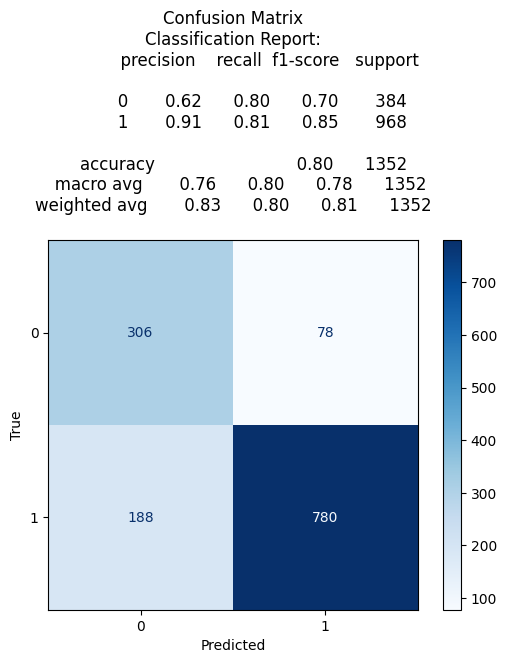

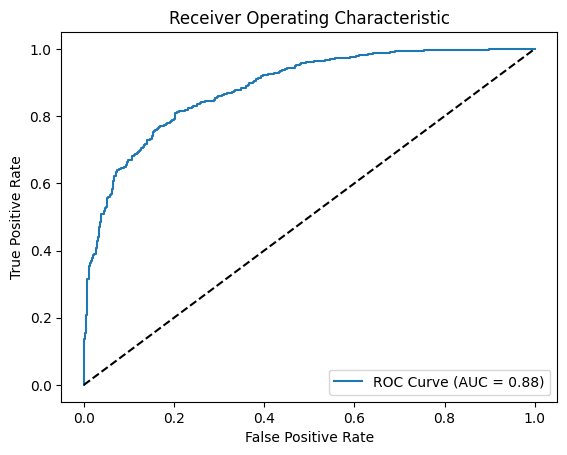

0.8841226540977962


In [99]:
def log_model_reg_oversample(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)
    # print(len(train_df.columns))
    train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train_amnities(train_df)
    X_test,Y_test = prepare_data_for_fitting_log_lin_test_amnities(test_df, train_scaler, train_encoder, columns_to_drop)


    # Extract the features and target variable from train_df
    y_train = target_column
    X_train = train_log_df

    # Create an instance of LogisticRegression classifier
    logistic_classifier = MyLogisticRegression(learning_rate=0.85,n_iterations=19000)



    # # Fit the classifier to the training data
    logistic_classifier.fit(X_train, y_train)
    # print(len(test_df.columns))
    # X_test = drop_low_correlation_columns(X_test,0.02,columns_to_drop)
    y_pred = logistic_classifier.predict(X_test)
    y_pred_proba = logistic_classifier.predict_proba(X_test)
    # y_pred_proba=y_pred_proba[:,1]
    plot_confusion_matrix(Y_test,y_pred)
    # print(f'learning_rate is = {learning_rate}')
    auc2 = roc_auc(Y_test,y_pred_proba)
    # print(auc)
    auc1 = roc_auc_score(Y_test,y_pred_proba)
    print(auc1)


    return None

work_df = pd.read_csv("/content/sample_data/train.csv")
log_model_reg_oversample(work_df)


54


<ipython-input-104-ed222074c430>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_df.corr()['expensive'].abs().sort_values(ascending=False)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


"['host_id'] not found in axis"
54
"['host_id'] not found in axis"
Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_

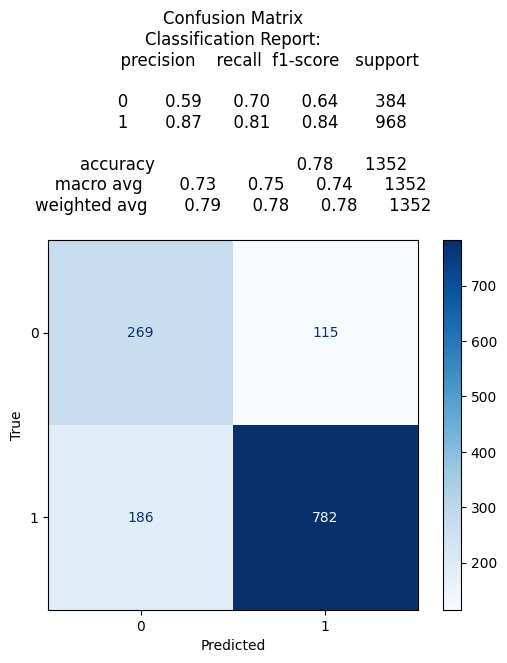

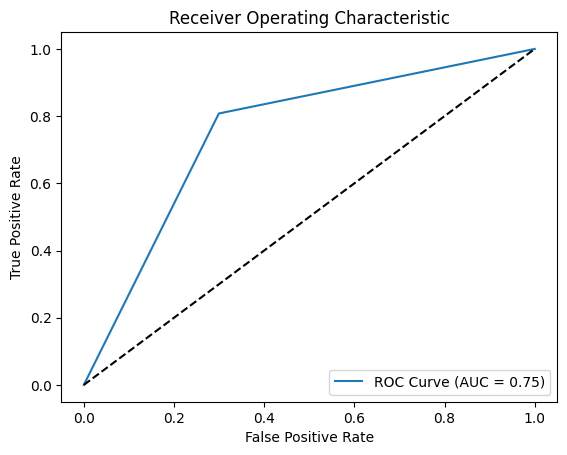

In [ ]:
def log_model_reg_oversample(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)
    print(len(train_df.columns))
    train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train_oversample(train_df)
    # train_log_df['expensive'] = target_column
    # train_log_df = detect_outliers_lof(train_log_df)
    # target_column = train_log_df['expensive']
    # train_log_df = train_log_df.drop('expensive',axis=1)
    # print(f'number of columns = {train_log_df.columns}')
    # train_log_df,columns_to_drop = drop_low_correlation_columns(train_log_df)

    # Extract the features and target variable from train_df
    y_train = target_column
    X_train = train_log_df

    # Create an instance of LogisticRegression classifier
    logistic_classifier = MyLogisticRegression()

    # # Perform cross-validation
    # scores = cross_val_score(logistic_classifier, X_train, y_train, cv=10, scoring='accuracy')
    # print('Cross-Validation Scores:', scores)
    # print('Mean Accuracy:', scores.mean())

    # # Fit the classifier to the training data
    logistic_classifier.fit(X_train, y_train)
    print(len(test_df.columns))
    X_test,Y_test = prepare_data_for_fitting_log_lin_test_1(test_df, train_scaler, train_encoder, columns_to_drop)
    # X_test = drop_low_correlation_columns(X_test,0.02,columns_to_drop)
    y_pred = logistic_classifier.predict(X_test)
    plot_confusion_matrix(Y_test,y_pred)
    roc_auc(Y_test,y_pred)


    return None

work_df = pd.read_csv("/content/sample_data/train.csv")
log_model_reg_oversample(work_df)


<ipython-input-10-ed222074c430>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_df.corr()['expensive'].abs().sort_values(ascending=False)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


"['host_id'] not found in axis"
54
"['host_id'] not found in axis"
Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_

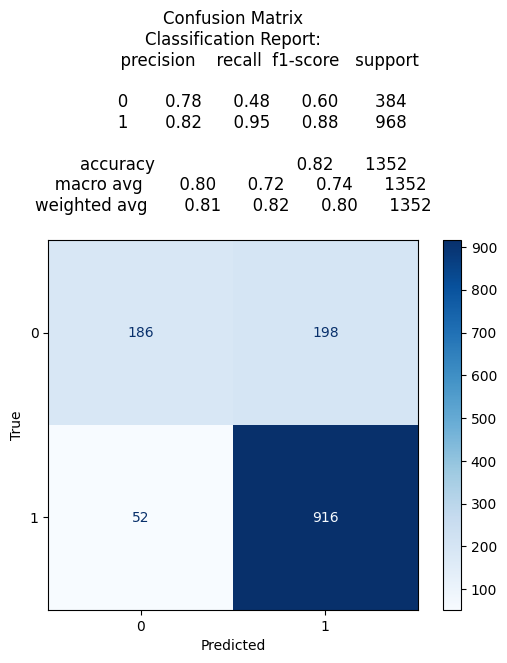

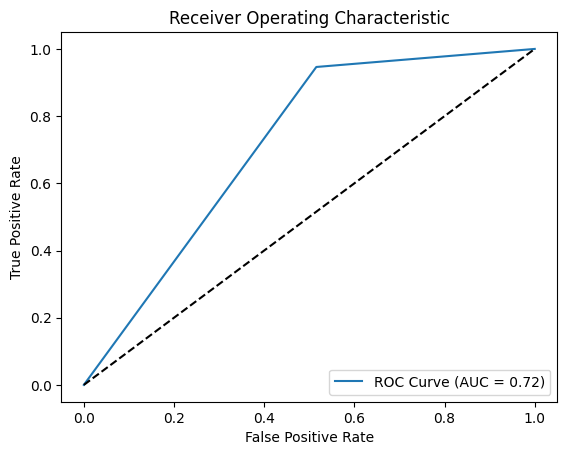

In [ ]:
def log_model_reg_oversample(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)
    # train_df = balance_dataframe(train_df)
    train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train(train_df)

    # Select the best features for training data
    selected_features = select_k_best_features(train_log_df, target_column, k=50, score_func=f_classif)
    train_log_df = train_log_df[selected_features]

    # Fit the classifier to the training data
    logistic_classifier = MyLogisticRegression()
    logistic_classifier.fit(train_log_df, target_column)

    print(len(test_df.columns))
    X_test, Y_test = prepare_data_for_fitting_log_lin_test(test_df, train_scaler, train_encoder, columns_to_drop)

    # Select the best features for test data
    X_test = X_test[selected_features]

    y_pred = logistic_classifier.predict(X_test)
    plot_confusion_matrix(Y_test, y_pred)
    roc_auc(Y_test, y_pred)

    return None

work_df = pd.read_csv("/content/sample_data/train.csv")
log_model_reg_oversample(work_df)


In [ ]:
def select_k_best_features(train_data, target, k=10, score_func =f_classif):
    # Create an instance of SelectKBest and specify the scoring function
    selector = SelectKBest(score_func=score_func, k=k)

    # Fit the selector on the training data
    selector.fit(train_data, target)

    # Get the selected feature indices
    selected_feature_indices = selector.get_support(indices=True)

    # Get the selected feature column names
    selected_feature_names = train_data.columns[selected_feature_indices]

    # Return the selected feature column names
    return selected_feature_names


In [ ]:
train_log_df['expensive'] = target_column
train_log_df['expensive'].value_counts()


1    4846
0    4846
Name: expensive, dtype: int64

##### Regular Not blanaced train

<ipython-input-1-866923bbaa48>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_df.corr()['expensive'].abs().sort_values(ascending=False)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


"['host_id', 'host_response_rate'] not found in axis"
Cross-Validation Scores: [0.94072165 0.95103093 0.95360825 0.95360825 0.95876289 0.93556701
 0.93023256 0.95348837 0.93041237 0.95103093]
Mean Accuracy: 0.9458463198273794
"['host_id', 'host_response_rate'] not found in axis"


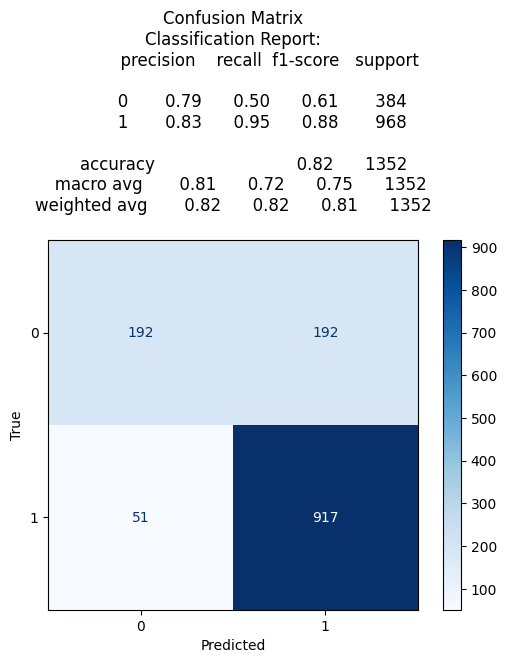

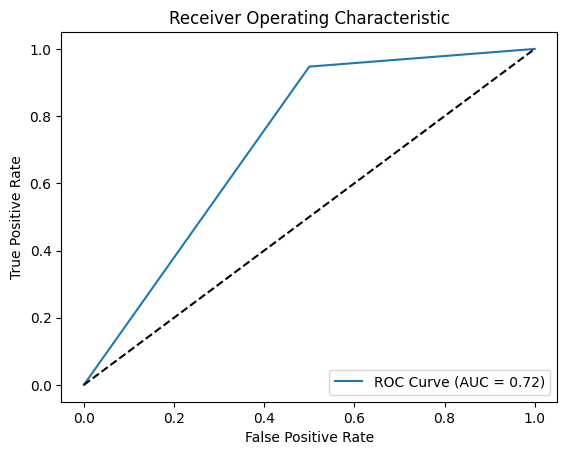

In [ ]:
def log_model_reg(df):

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)
    # train_df = balance_dataframe(train_df)
    train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train(train_df)

    # Extract the features and target variable from train_df
    y_train = target_column
    X_train = train_log_df

    # Create an instance of LogisticRegression classifier
    logistic_classifier = MyLogisticRegression()

    # # Perform cross-validation
    scores = cross_val_score(logistic_classifier, X_train, y_train, cv=10, scoring='accuracy')
    print('Cross-Validation Scores:', scores)
    print('Mean Accuracy:', scores.mean())

    # # Fit the classifier to the training data
    logistic_classifier.fit(X_train, y_train)

    X_test,Y_test = prepare_data_for_fitting_log_lin_test(test_df, train_scaler, train_encoder, columns_to_drop)
    y_pred = logistic_classifier.predict(X_test)
    plot_confusion_matrix(Y_test,y_pred)
    roc_auc(Y_test,y_pred)


    return None

work_df = pd.read_csv("/content/sample_data/train.csv")
log_model_reg(work_df)


#### Irrelavant tests

##### Fancy Log_reg_model

In [ ]:
def log_model_reg_fancy(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)
    train_df = balance_dataframe(train_df)
    train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train_fancy(train_df)

    # Extract the features and target variable from train_df
    y_train = target_column
    X_train = train_log_df

    # Create an instance of LogisticRegression classifier
    logistic_classifier = NevoLogisticRegression()

    # # Perform cross-validation
    scores = cross_val_score(logistic_classifier, X_train, y_train, cv=10, scoring='accuracy')
    print('Cross-Validation Scores:', scores)
    print('Mean Accuracy:', scores.mean())

    # # Fit the classifier to the training data
    logistic_classifier.fit(X_train, y_train)

    X_test,Y_test = prepare_data_for_fitting_public_test_fancy(test_df, train_scaler, train_encoder, columns_to_drop)
    y_pred = logistic_classifier.predict(X_test)
    plot_confusion_matrix(Y_test,y_pred)
    roc_auc(Y_test,y_pred)


    return None

work_df = pd.read_csv("/content/sample_data/train.csv")
log_model_reg_fancy(work_df)

##### Standart Log_reg_model with balanced data

In [ ]:
def log_model_reg_standart(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)
    train_df = balance_dataframe(train_df)
    train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train_standart(train_df)

    # Extract the features and target variable from train_df
    y_train = target_column
    X_train = train_log_df

    # Create an instance of LogisticRegression classifier
    logistic_classifier = MyLogisticRegression()

    # # Perform cross-validation
    # scores = cross_val_score(logistic_classifier, X_train, y_train, cv=10, scoring='accuracy')
    # print('Cross-Validation Scores:', scores)
    # print('Mean Accuracy:', scores.mean())

    # # Fit the classifier to the training data
    logistic_classifier.fit(X_train, y_train)

    X_test,Y_test = prepare_data_for_fitting_log_lin_test_standart(test_df, train_scaler, train_encoder, columns_to_drop)
    y_pred = logistic_classifier.predict(X_test)
    print(y_pred)
    # plot_confusion_matrix(Y_test,y_pred)
    # roc_auc(Y_test,y_pred)


    return None

work_df = pd.read_csv("/content/sample_data/train.csv")
log_model_reg_standart(work_df)


<ipython-input-1-866923bbaa48>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_df.corr()['expensive'].abs().sort_values(ascending=False)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


"['host_response_rate'] not found in axis"
"['host_response_rate'] not found in axis"
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1

In [ ]:
work_df = pd.read_csv("/content/sample_data/train.csv")
train_df, test_df = train_test_split(work_df, test_size=0.2, random_state=2023)
train_df = balance_dataframe(train_df)
train_log_df_noramlized, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train(train_df)
train_log_df_noramlized.head(10)



<ipython-input-6-020301ae9598>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['first_review'] = pd.to_datetime(df['first_review'])
<ipython-input-6-020301ae9598>:22: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['last_review'] = pd.to_datetime(df['last_review'])
<ipython-input-1-866923bbaa48>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_df.corr()['expensive'].abs().sort_values(ascending=False)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` w

"['host_response_rate'] not found in axis"


,host_response_time_Unknown,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_f,host_is_superhost_t,"host_verifications_['email', 'phone', 'work_email']","host_verifications_['email', 'phone']","host_verifications_['email', 'work_email']",...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,response_rate_over_80,acceptance_rate_over_80,amenities_length,months_between_reviews,average_availability,num_baths
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.103896,0.00000,0.0,0.046198,1.0,1.0,0.152174,0.382713,0.638532,0.090909
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,0.06250,0.0,0.118692,1.0,1.0,0.195652,0.105181,0.286239,0.090909
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,0.03125,0.0,0.002132,1.0,1.0,0.184783,0.320489,0.185321,0.090909
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.000000,0.03125,0.0,0.081734,1.0,1.0,0.391304,0.518615,0.099083,0.090909
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.051948,0.00000,0.0,0.066971,0.0,1.0,0.217391,0.346237,0.005505,0.090909
5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.000000,0.09375,0.0,0.028429,1.0,1.0,0.380435,0.573288,0.394495,0.181818
6,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.311688,0.00000,0.0,0.066971,1.0,1.0,0.184783,0.346237,0.388991,0.090909
7,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.051948,0.00000,0.0,0.110163,1.0,1.0,0.293478,0.608956,0.429358,0.090909
8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.000000,0.06250,0.0,0.067520,1.0,1.0,0.304348,0.692268,0.141284,0.117691
9,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.090909,0.00000,0.0,0.066971,1.0,1.0,0.347826,0.346237,0.154128,0.090909


In [ ]:
work_df = pd.read_csv("/content/sample_data/train.csv")
train_df, test_df = train_test_split(work_df, test_size=0.2, random_state=2023)
train_log_df_standatized, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train_standart(train_df)
train_log_df_standatized.head(10)

<ipython-input-6-020301ae9598>:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['first_review'] = pd.to_datetime(df['first_review'])
<ipython-input-6-020301ae9598>:22: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['last_review'] = pd.to_datetime(df['last_review'])
<ipython-input-1-866923bbaa48>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_df.corr()['expensive'].abs().sort_values(ascending=False)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` w

"['host_response_rate'] not found in axis"


,host_response_time_Unknown,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_f,host_is_superhost_t,"host_verifications_['email', 'phone', 'work_email']","host_verifications_['email', 'phone']","host_verifications_['email', 'work_email']",...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,response_rate_over_80,acceptance_rate_over_80,amenities_length,months_between_reviews,average_availability,num_baths
3719,-0.308935,-0.09759,-0.170664,3.710861,-2.047702,0.600570,-0.600570,3.286867,-2.431675,-0.033333,...,-0.375550,-0.246436,-0.171781,-0.864029,0.357953,0.410009,-1.331635,-0.835731,0.109593,-0.379939
2233,-0.308935,-0.09759,-0.170664,-0.269479,0.488352,0.600570,-0.600570,-0.304241,0.411239,-0.033333,...,-0.283439,-0.446831,-0.171781,-0.873390,0.357953,0.410009,-0.621852,-1.568631,1.569603,-0.379939
3066,-0.308935,-0.09759,-0.170664,-0.269479,0.488352,0.600570,-0.600570,-0.304241,0.411239,-0.033333,...,-0.559773,-0.446831,-0.171781,0.764781,0.357953,0.410009,1.608894,1.069810,-0.267873,-0.379939
774,-0.308935,-0.09759,-0.170664,-0.269479,0.488352,-1.665084,1.665084,-0.304241,0.411239,-0.033333,...,0.821896,0.354752,-0.171781,0.418425,0.357953,0.410009,0.087930,0.054550,0.679353,-0.379939
1711,-0.308935,-0.09759,-0.170664,3.710861,-2.047702,-1.665084,1.665084,-0.304241,0.411239,-0.033333,...,-0.467662,-0.446831,-0.171781,-0.171316,0.357953,0.410009,-0.317660,0.809052,-0.802024,-0.379939
2446,-0.308935,-0.09759,-0.170664,-0.269479,0.488352,-1.665084,1.665084,-0.304241,0.411239,-0.033333,...,-0.743995,4.963855,-0.171781,-0.892112,0.357953,0.410009,-1.534430,-1.618005,-1.443004,-0.379939
1673,-0.308935,-0.09759,-0.170664,-0.269479,0.488352,-1.665084,1.665084,-0.304241,0.411239,-0.033333,...,0.085006,-0.446831,-0.171781,0.661810,0.357953,0.410009,0.493521,0.697959,-0.303483,-0.379939
2297,-0.308935,-0.09759,-0.170664,-0.269479,0.488352,0.600570,-0.600570,-0.304241,0.411239,-0.033333,...,-0.651884,-0.446831,-0.171781,0.240566,0.357953,0.410009,0.594918,1.116098,0.650865,-0.379939
3722,-0.308935,-0.09759,-0.170664,-0.269479,0.488352,0.600570,-0.600570,-0.304241,0.411239,-0.033333,...,-0.283439,-0.446831,-0.171781,3.432659,0.357953,0.410009,-1.128840,1.038951,0.914379,-0.379939
4572,-0.308935,-0.09759,-0.170664,-0.269479,0.488352,0.600570,-0.600570,-0.304241,0.411239,-0.033333,...,-0.651884,-0.246436,-0.171781,-0.349175,0.357953,0.410009,-0.824648,-0.584230,-0.802024,-0.379939


54


<ipython-input-48-ed222074c430>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_df.corr()['expensive'].abs().sort_values(ascending=False)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


auc score for newton-cg is 0.8826699164944902


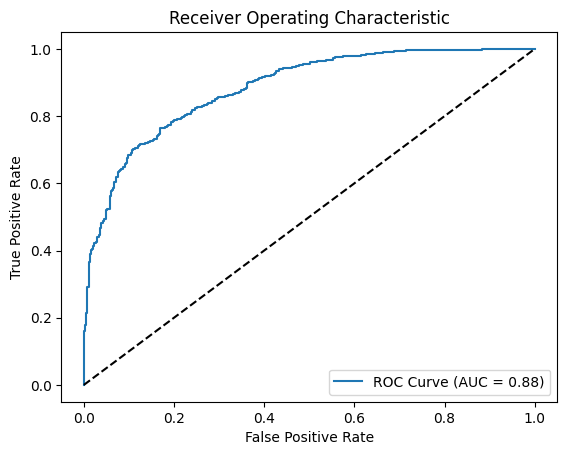

auc score for lbfgs is 0.8826726067493114


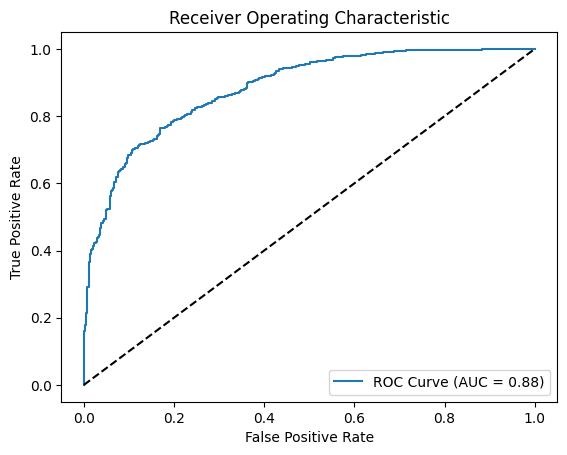

auc score for liblinear is 0.882643013946281


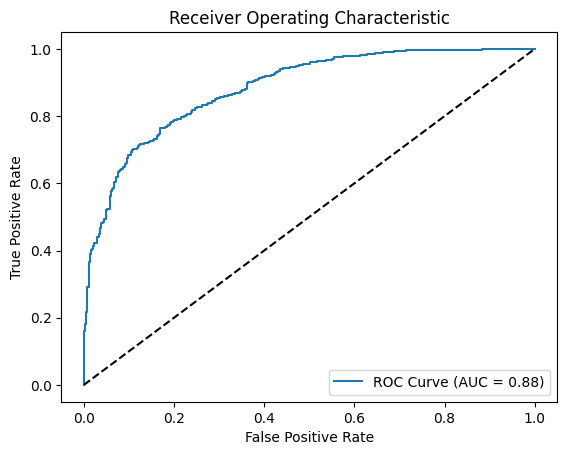

auc score for sag is 0.8826537749655647


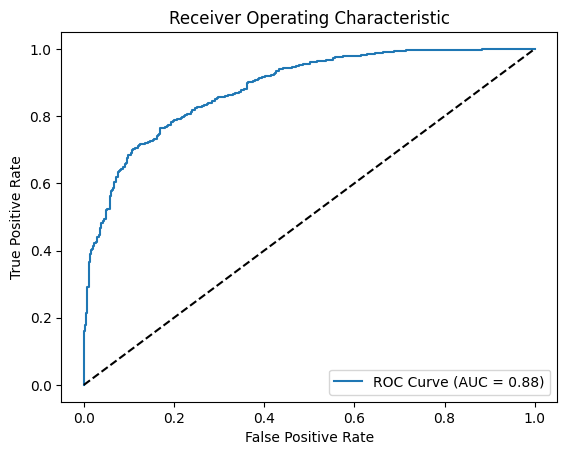

auc score for saga is 0.8826618457300275


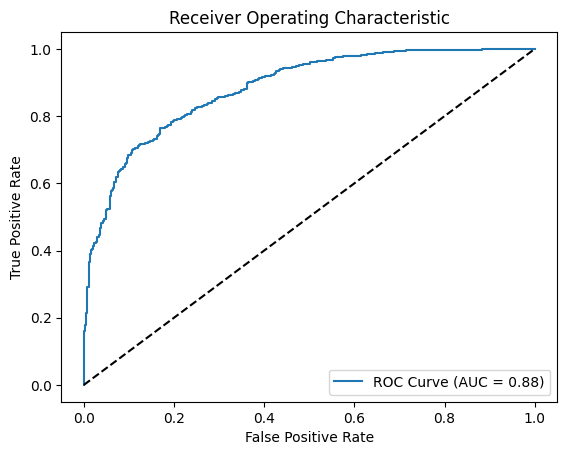

Best solver: lbfgs
Best AUC score: 0.8826726067493114


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

def log_model_reg_oversample(df):
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=2023)
    print(len(train_df.columns))
    train_log_df, train_scaler, target_column, train_encoder, columns_to_drop = prepare_data_for_fitting_log_lin_train_amnities(train_df)
    # train_log_df['expensive'] = target_column
    # train_log_df = detect_outliers_lof(train_log_df)
    # target_column = train_log_df['expensive']
    # train_log_df = train_log_df.drop('expensive', axis=1)
    # print(f'number of columns = {train_log_df.columns}')
    # train_log_df, columns_to_drop = drop_low_correlation_columns(train_log_df)

    # Extract the features and target variable from train_df
    y_train = target_column
    X_train = train_log_df

    solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    best_auc = 0
    best_solver = None
    X_test, Y_test = prepare_data_for_fitting_log_lin_test_amnities(test_df, train_scaler, train_encoder, columns_to_drop)
    for solver in solvers:
        # Create an instance of LogisticRegression classifier with the current solver
        logistic_classifier = LogisticRegression(solver=solver,max_iter=3500)

        # Fit the classifier to the training data
        logistic_classifier.fit(X_train, y_train)



        # Make predictions on the test data
        y_pred_proba = logistic_classifier.predict_proba(X_test)[:, 1]

        # Calculate the AUC score
        auc = roc_auc_score(Y_test, y_pred_proba)
        print(f'auc score for {solver} is {auc}')
        # Check if this solver achieved a better AUC score
        if auc > best_auc:
            best_auc = auc
            best_solver = solver
        # plot_confusion_matrix(Y_test,y_pred)
        roc_auc(Y_test,y_pred_proba)
    print("Best solver:", best_solver)
    print("Best AUC score:", best_auc)

    return None
work_df = pd.read_csv("/content/sample_data/train.csv")
log_model_reg_oversample(work_df)

## Public Testing

##### Help Functions

In [32]:
def plot_counts(counts):
    bins = np.arange(0, 1.2, 0.2)
    labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins) - 1)]

    # Group the counts based on the specified bins
    grouped_counts = counts.groupby(pd.cut(counts.index, bins=bins)).sum()

    plt.bar(labels, grouped_counts)
    plt.xlabel('Range')
    plt.ylabel('Count')
    plt.title('Prediction Counts by Range')
    plt.show()

def save_predictions_csv(predictions, output_path):
    # Convert the NumPy array to a Series
    public_test_pred_series = pd.Series(predictions)

    # Concatenate the Series with public_test_df['id']
    preds = pd.concat([public_test_df['id'], public_test_pred_series], axis=1)

    # Assign a new column name 'expensive' to the second column
    preds.columns = ['id', 'expensive']

    # print(preds['expensive'].value_counts)


    # Save the predictions to a CSV file without the index column
    preds.to_csv(output_path, index=False)

def create_pred_df(predictions):
    # Convert the NumPy array to a Series
    public_test_pred_series = pd.Series(predictions)

    # Concatenate the Series with public_test_df['id']
    preds = pd.concat([public_test_df['id'], public_test_pred_series], axis=1)

    # Assign a new column name 'expensive' to the second column
    preds.columns = ['id', 'expensive']

    return preds

def show_counts(predictions):
    # Convert the NumPy array to a Series
    public_test_pred_series = pd.Series(predictions)

    # Concatenate the Series with public_test_df['id']
    preds = pd.concat([public_test_df['id'], public_test_pred_series], axis=1)

    # Assign a new column name 'expensive' to the second column
    preds.columns = ['id', 'expensive']

    plot_counts(preds['expensive'].value_counts())
    return preds




##### My Logistic Regression

In [93]:
work_df = pd.read_csv("/content/sample_data/train.csv")
public_test_df = pd.read_csv("/content/sample_data/test.csv")


def log_model(train_df,real_test):
  train_log_df , train_scaler , target_column,train_encoder,columns_to_drop = prepare_data_for_fitting_log_lin_train_amnities(train_df)

  y_train = target_column
  X_train = train_log_df

  # Create an instance of LogisticRegression classifier
  logistic_classifier = MyLogisticRegression(learning_rate=0.8,n_iterations=10000)

  # Perform cross-validation
  scores = cross_val_score(logistic_classifier, X_train, y_train, cv=5, scoring='accuracy')
  print('Cross-Validation Scores:', scores)
  print('Mean Accuracy:', scores.mean())

  # Fit the classifier to the training data
  logistic_classifier.fit(X_train, y_train)



  X_test = prepare_data_for_fitting_public_test_amnities(real_test, train_scaler,train_encoder,columns_to_drop)




  y_pred = logistic_classifier.predict_proba(X_test)


  return y_pred

pred_0_8_10000 = log_model(work_df,public_test_df)



Cross-Validation Scores: [0.78442496 0.7643115  0.80598555 0.80288958 0.79153767]
Mean Accuracy: 0.7898298517582979


##### CSV Submission learning rate = 1.1 , iterations = 3500



In [ ]:
work_df = pd.read_csv("/content/sample_data/train.csv")
public_test_df = pd.read_csv("/content/sample_data/test.csv")


def log_model(train_df,real_test):
  train_log_df , train_scaler , target_column,train_encoder,columns_to_drop = prepare_data_for_fitting_log_lin_train_amnities(train_df)

  y_train = target_column
  X_train = train_log_df

  # Create an instance of LogisticRegression classifier
  logistic_classifier = MyLogisticRegression(learning_rate=1.1,n_iterations=3500)

  # Perform cross-validation
  scores = cross_val_score(logistic_classifier, X_train, y_train, cv=5, scoring='accuracy')
  print('Cross-Validation Scores:', scores)
  print('Mean Accuracy:', scores.mean())

  # Fit the classifier to the training data
  logistic_classifier.fit(X_train, y_train)



  X_test = prepare_data_for_fitting_public_test_amnities(real_test, train_scaler,train_encoder,columns_to_drop)




  y_pred = logistic_classifier.predict_proba(X_test)


  return y_pred

pred_1_1_3500 = log_model(work_df,public_test_df)



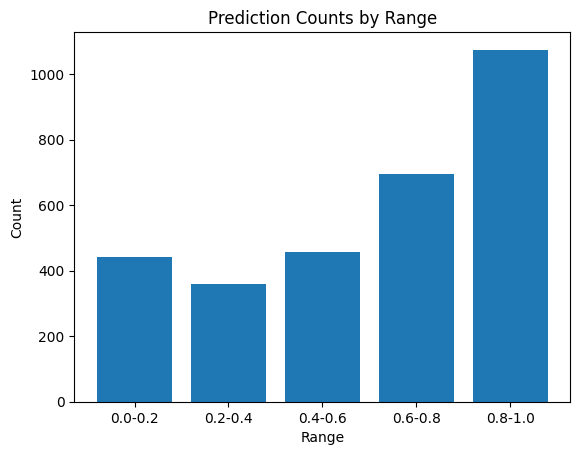

In [30]:
preds = show_counts(pred_1_1_3500)
save_predictions_csv(pred_1_1_3500,'pred_hyperparameters_fixed_iter=3500_learnin=1.1_with_amnities.csv')

In [33]:
pred_1_1_3500_df = create_pred_df(pred_1_1_3500)
pred_1_1_3500_df

,id,expensive
0,6760,0.507330
1,6761,0.928094
2,6762,0.416567
3,6763,0.613015
4,6764,0.416306
...,...,...
3022,9782,0.875940
3023,9783,0.936263
3024,9784,0.930387
3025,9785,0.329709


##### CSV Submission learning rate = 0,85 , iterations = 19000



In [100]:
work_df = pd.read_csv("/content/sample_data/train.csv")
public_test_df = pd.read_csv("/content/sample_data/test.csv")


def log_model(train_df,real_test):
  train_log_df , train_scaler , target_column,train_encoder,columns_to_drop = prepare_data_for_fitting_log_lin_train_amnities(train_df)

  y_train = target_column
  X_train = train_log_df

  # Create an instance of LogisticRegression classifier
  logistic_classifier = MyLogisticRegression(learning_rate=0.85,n_iterations=19000)

  # Perform cross-validation
  scores = cross_val_score(logistic_classifier, X_train, y_train, cv=5, scoring='accuracy')
  print('Cross-Validation Scores:', scores)
  print('Mean Accuracy:', scores.mean())

  # Fit the classifier to the training data
  logistic_classifier.fit(X_train, y_train)



  X_test = prepare_data_for_fitting_public_test_amnities(real_test, train_scaler,train_encoder,columns_to_drop)




  y_pred = logistic_classifier.predict_proba(X_test)


  return y_pred

pred_0_85_19000 = log_model(work_df,public_test_df)



Cross-Validation Scores: [0.78545642 0.77204745 0.81527348 0.80134159 0.78173375]
Mean Accuracy: 0.7911705362365353


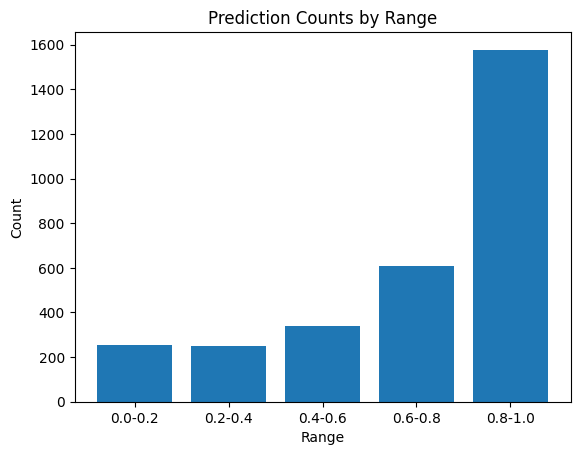

In [101]:
# pred_1_1_3000
preds = show_counts(pred_0_85_19000)
save_predictions_csv(pred_0_85_19000,'pred_hyperparameters_fixed_iter=19000_learnin=0.85_with_amnities.csv')

In [102]:
pred_0_85_19000_df = create_pred_df(pred_0_85_19000)
pred_0_85_19000_df

,id,expensive
0,6760,0.659584
1,6761,0.955929
2,6762,0.645791
3,6763,0.745175
4,6764,0.645265
...,...,...
3022,9782,0.938098
3023,9783,0.958849
3024,9784,0.955447
3025,9785,0.474447


##### CSV Submission learning rate = 1.1 , iterations = 3000









In [ ]:
work_df = pd.read_csv("/content/sample_data/train.csv")
public_test_df = pd.read_csv("/content/sample_data/test.csv")


def log_model(train_df,real_test):
  train_log_df , train_scaler , target_column,train_encoder,columns_to_drop = prepare_data_for_fitting_log_lin_train_amnities(train_df)

  y_train = target_column
  X_train = train_log_df

  # Create an instance of LogisticRegression classifier
  logistic_classifier = MyLogisticRegression(learning_rate=1.1,n_iterations=3000)

  # Perform cross-validation
  scores = cross_val_score(logistic_classifier, X_train, y_train, cv=5, scoring='accuracy')
  print('Cross-Validation Scores:', scores)
  print('Mean Accuracy:', scores.mean())

  # Fit the classifier to the training data
  logistic_classifier.fit(X_train, y_train)



  X_test = prepare_data_for_fitting_public_test_amnities(real_test, train_scaler,train_encoder,columns_to_drop)




  y_pred = logistic_classifier.predict_proba(X_test)


  return y_pred

pred_1_1_3000 = log_model(work_df,public_test_df)



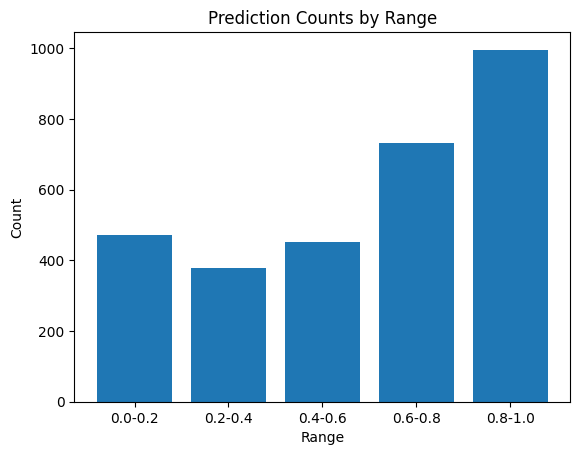

In [41]:
# pred_1_1_3000
preds = show_counts(pred_1_1_3000)
save_predictions_csv(pred_1_1_3000,'pred_hyperparameters_fixed_iter=3000_learnin=1.10_with_amnities.csv')

In [42]:
pred_1_1_3000_df = create_pred_df(pred_1_1_3000)
pred_1_1_3000_df

,id,expensive
0,6760,0.467057
1,6761,0.897282
2,6762,0.389934
3,6763,0.555940
4,6764,0.389689
...,...,...
3022,9782,0.880707
3023,9783,0.923442
3024,9784,0.916923
3025,9785,0.298013


##### CSV Submission learning rate = 0.8 , iterations = 10000

In [ ]:
work_df = pd.read_csv("/content/sample_data/train.csv")
public_test_df = pd.read_csv("/content/sample_data/test.csv")


def log_model(train_df,real_test):
  train_log_df , train_scaler , target_column,train_encoder,columns_to_drop = prepare_data_for_fitting_log_lin_train_amnities(train_df)

  y_train = target_column
  X_train = train_log_df

  # Create an instance of LogisticRegression classifier
  logistic_classifier = MyLogisticRegression(learning_rate=0.8,n_iterations=10000)

  # Perform cross-validation
  scores = cross_val_score(logistic_classifier, X_train, y_train, cv=5, scoring='accuracy')
  print('Cross-Validation Scores:', scores)
  print('Mean Accuracy:', scores.mean())

  # Fit the classifier to the training data
  logistic_classifier.fit(X_train, y_train)



  X_test = prepare_data_for_fitting_public_test_amnities(real_test, train_scaler,train_encoder,columns_to_drop)




  y_pred = logistic_classifier.predict_proba(X_test)


  return y_pred

pred_0_8_10000 = log_model(work_df,public_test_df)



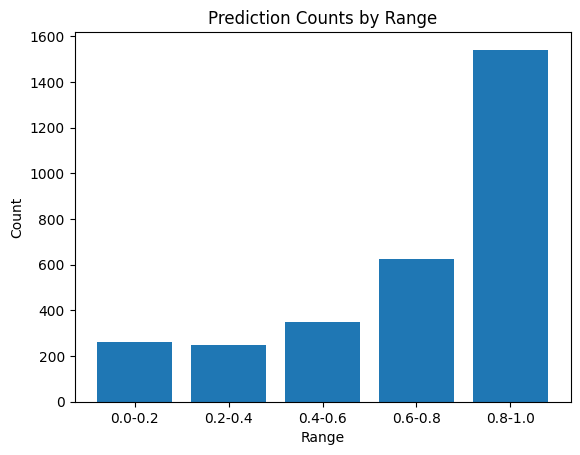

In [94]:
# pred_0_8_10000
preds = show_counts(pred_0_8_10000)
save_predictions_csv(pred_0_8_10000,'pred_hyperparameters_fixed_iter=10000_learnin=0.8_with_amnities.csv')

In [95]:
pred_0_8_10000_df = create_pred_df(pred_0_8_10000)
pred_0_8_10000_df

,id,expensive
0,6760,0.688761
1,6761,0.952554
2,6762,0.574781
3,6763,0.760785
4,6764,0.574381
...,...,...
3022,9782,0.945762
3023,9783,0.964540
3024,9784,0.961406
3025,9785,0.502910
